In [1]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm

# for hyperparemeter optimisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
#import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

!pip install lifelines
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter, KaplanMeierFitter



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
meth = pd.read_csv('C:/Users/shubh/Downloads/liver/methy',delim_whitespace=True).transpose(copy = True)
mirna = pd.read_csv('C:/Users/shubh/Downloads/liver/mirna',delim_whitespace=True).transpose(copy = True)
exp = pd.read_csv('C:/Users/shubh/Downloads/liver/exp',delim_whitespace=True).transpose(copy = True)
surv = pd.read_csv('C:/Users/shubh/Downloads/liver/survival',delim_whitespace=True, index_col=0)
clinic = pd.read_csv('C:/Users/shubh/Downloads/liver/20150821-LIHC-Clinical.txt', index_col=0, sep='\t').transpose(copy = True)


# Exploratory Data Analysis

The initial exploratory data analysis is the same as done in the other analyses. However, here it is performed to merge data from all relevant sources(mrna, mirna, methylation,clinical data), resulting in a comprehensive dataset with all the required columns. This merged data will be readily available for conducting survival analysis. From this merged dataframe, we will directly select a subset of the most significant columns that we obtained earlier from machine learning analysis.

In [4]:
#analysing mrna data
exp.head()

,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..136542,X..155060,X..26823,X..280660,X..317712,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
TCGA.2V.A95S.01,0.0,1.5051,3.7074,90.1124,1017.1038,0.0,141.3911,0.6516,0.0000,0.0,...,24.7597,273.6602,794.2662,18.2440,499.1041,3172.5037,890.0472,510.1808,3.9094,6.5157
TCGA.2Y.A9GS.01,0.0,26.4120,2.6663,71.0054,639.2311,0.0,122.7206,1.4786,0.0000,0.0,...,68.5067,632.8241,1153.7703,71.4638,1000.4929,5301.1336,755.5446,860.5224,6.4071,482.9966
TCGA.2Y.A9GT.01,0.0,0.0000,4.4833,95.5122,742.4344,0.0,95.0460,1.7933,0.8967,0.0,...,46.6263,1219.4575,1133.3782,12.5532,1289.3970,3219.0092,860.7935,523.6494,14.3466,83.3894
TCGA.2Y.A9GU.01,0.0,5.7222,5.1216,61.6679,1186.9807,0.0,280.2709,0.8341,0.0000,0.0,...,18.3511,285.2758,1150.2786,9.1755,941.7437,3092.9899,1339.6283,343.6655,2.5024,2.5024
TCGA.2Y.A9GV.01,0.0,11.4975,5.4230,104.4670,878.1726,0.0,282.5719,0.0000,0.0000,0.0,...,41.4552,999.1540,1631.9797,4.2301,1380.7107,2902.7073,575.2961,665.8206,2.5381,119.2893


In [5]:
#analysing mirna data
mirna.head()

,hsa.let.7a.1,hsa.let.7a.2,hsa.let.7a.3,hsa.let.7b,hsa.let.7c,hsa.let.7d,hsa.let.7e,hsa.let.7f.1,hsa.let.7f.2,hsa.let.7g,...,hsa.mir.941.3,hsa.mir.941.4,hsa.mir.942,hsa.mir.943,hsa.mir.944,hsa.mir.95,hsa.mir.96,hsa.mir.98,hsa.mir.99a,hsa.mir.99b
TCGA.2V.A95S.01,4045.749542,8128.517796,4073.455371,7810.249993,314.077006,403.946335,254.008905,56.342947,6920.869591,756.438986,...,0.0,0.0,7.915951,0.000000,0.465644,2.793865,16.297547,36.320247,85.445709,3479.293385
TCGA.2Y.A9GS.01,7077.368096,14213.530526,7151.760928,6912.683963,1827.573913,264.424523,1297.374998,15.448512,8220.257978,492.552543,...,0.0,0.0,14.098642,0.000000,2.099798,19.198150,21.597919,28.347269,1056.948163,14142.887333
TCGA.2Y.A9GT.01,8956.551210,18087.355487,8961.344580,18312.925799,3968.627681,331.588359,843.632968,33.271621,11744.036344,814.590790,...,0.0,0.0,8.458887,0.000000,0.563926,1.973740,4.793369,32.707695,1124.186044,10024.062713
TCGA.2Y.A9GU.01,4859.044531,9760.356325,4853.452247,4755.522250,273.631757,305.754876,375.723453,11.054515,10263.141672,341.649537,...,0.0,0.0,1.690691,0.260106,0.130053,3.251328,40.966732,46.819122,92.467766,3933.716609
TCGA.2Y.A9GV.01,7103.556987,14113.799596,7146.959023,8815.224783,3936.835932,478.778710,589.182639,18.174603,11091.661574,852.307483,...,0.0,0.0,9.494195,0.000000,2.712627,7.866619,5.425255,42.045722,1544.298695,9489.312656


In [6]:
#analysing methylation data
meth.head()

,cg00005740,cg00012529,cg00013196,cg00019366,cg00028598,cg00030627,cg00033551,cg00047815,cg00049102,cg00049709,...,rs7660805,rs7746156,rs798149,rs845016,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367
TCGA.2V.A95S.01,0.601838,0.374335,0.300235,0.259656,0.311692,0.331413,0.963102,0.586768,0.693580,0.411080,...,0.944546,0.959710,0.969422,0.368036,0.513791,0.509061,0.541551,0.562851,0.495167,0.048576
TCGA.2Y.A9GS.01,0.399472,0.395836,0.395846,0.380457,0.273681,0.446539,0.952035,0.380159,0.513627,0.267730,...,0.334419,0.459250,0.971834,0.933756,0.521390,0.020679,0.573997,0.960284,0.037918,0.473765
TCGA.2Y.A9GT.01,0.438239,0.640740,0.477210,0.519875,0.377109,0.450508,0.604261,0.558608,0.792885,0.427334,...,0.511502,0.462957,0.018341,0.951748,0.544744,0.025068,0.558837,0.966630,0.968370,0.948648
TCGA.2Y.A9GU.01,0.913263,0.969171,0.944687,0.573213,0.944506,0.934732,0.909746,0.883221,0.949313,0.887161,...,0.540377,0.487190,0.015734,0.945182,0.020356,0.521952,0.939739,0.966117,0.027995,0.949593
TCGA.2Y.A9GV.01,0.648241,0.805019,0.560080,0.914805,0.389027,0.641507,0.218462,0.559733,0.536288,0.351339,...,0.948858,0.957963,0.016105,0.940811,0.569243,0.967371,0.518856,0.523212,0.506449,0.037212


In [7]:
#analysing survival data
surv.head()

,Survival,Death
PatientID,,
TCGA-2V-A95S-01,NaN,NaN
TCGA-2Y-A9GS-01,724.0,1.0
TCGA-2Y-A9GT-01,1624.0,1.0
TCGA-2Y-A9GU-01,1939.0,0.0
TCGA-2Y-A9GV-01,2532.0,1.0


In [8]:
#analysing clinical data
clinic.head()

Hybridization REF,Composite Element REF,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,days_to_last_known_alive,radiation_therapy,histological_type,residual_tumor,race,ethnicity
tcga-2y-a9gs,value,58,1,724,NaN,liver,stage iv,t2,nx,mx,male,2006,NaN,no,hepatocellular carcinoma,r0,white,hispanic or latino
tcga-2y-a9gt,value,51,1,1624,NaN,liver,stage i,t1,nx,mx,male,2006,NaN,no,hepatocellular carcinoma,r0,white,not hispanic or latino
tcga-2y-a9gu,value,55,0,NaN,1939,liver,stage i,t1,nx,mx,female,2009,NaN,no,hepatocellular carcinoma,r0,white,not hispanic or latino
tcga-2y-a9gv,value,54,1,2532,NaN,liver,stage i,t1,nx,mx,female,2007,NaN,no,hepatocellular carcinoma,r0,white,not hispanic or latino
tcga-2y-a9gw,value,64,1,1271,NaN,liver,stage i,t1,n0,mx,male,2007,NaN,no,hepatocellular carcinoma,r0,white,not hispanic or latino


Looking at all the data, the sample ids look similar. The data is coming from the same patients

In [9]:
print(exp.shape)
print(mirna.shape)
print(meth.shape)
print(surv.shape)
print(clinic.shape)

(423, 20531)
(424, 1046)
(429, 5000)
(438, 2)
(368, 18)


In [10]:
surv

,Survival,Death
PatientID,,
TCGA-2V-A95S-01,NaN,NaN
TCGA-2Y-A9GS-01,724.0,1.0
TCGA-2Y-A9GT-01,1624.0,1.0
TCGA-2Y-A9GU-01,1939.0,0.0
TCGA-2Y-A9GV-01,2532.0,1.0
...,...,...
TCGA-ZS-A9CD-01,1386.0,1.0
TCGA-ZS-A9CE-01,1241.0,0.0
TCGA-ZS-A9CF-01,2412.0,0.0


In [11]:
#keeping a copy of clinic data, in case it's needed later
surv_compl = clinic.copy()
surv2 = surv.copy()

In [12]:
clinic.shape

(368, 18)

In [13]:
surv.index.str[:12].value_counts() > 1

TCGA-DD-A1EH     True
TCGA-G3-A25W     True
TCGA-DD-A11A     True
TCGA-DD-A119     True
TCGA-DD-A118     True
                ...  
TCGA-DD-AACC    False
TCGA-DD-AACB    False
TCGA-DD-AAC9    False
TCGA-DD-AAC8    False
TCGA-ZS-A9CG    False
Name: PatientID, Length: 377, dtype: bool

In [14]:
for index, row in surv[surv.index.str[:12] == "TCGA-DD-A1EH"].iterrows():
    print(row,"----------------------------------")

Survival    1495.0
Death          0.0
Name: TCGA-DD-A1EH-01, dtype: float64 ----------------------------------
Survival    1495.0
Death          0.0
Name: TCGA-DD-A1EH-11, dtype: float64 ----------------------------------


In [15]:
for index, row in surv[surv.index.str[:12] == "TCGA-G3-A25W"].iterrows():
    print(row,"----------------------------------")

Survival    935.0
Death         0.0
Name: TCGA-G3-A25W-01, dtype: float64 ----------------------------------
Survival    935.0
Death         0.0
Name: TCGA-G3-A25W-11, dtype: float64 ----------------------------------


Looking at the data, they just seem like duplicate rows. However since they might have different values in the mrna, mirna and methylation data, we will not remove them yet.

In [16]:
surv_compl.shape

(368, 18)

ANALYSING CLINICAL DATA :

Removing unnecessary columns

In [17]:
#Checking null and unique counts of values in the columns of clinical data
null_counts = clinic.isnull().sum()
unique_counts = clinic.nunique()
print("NULL COUNT:\n",null_counts)
print("\nUNIQUE COUNT:\n",unique_counts)

NULL COUNT:
 Hybridization REF
Composite Element REF                     0
years_to_birth                            3
vital_status                              0
days_to_death                           236
days_to_last_followup                    91
tumor_tissue_site                         0
pathologic_stage                         22
pathology_T_stage                         1
pathology_N_stage                         1
pathology_M_stage                         0
gender                                    0
date_of_initial_pathologic_diagnosis      2
days_to_last_known_alive                368
radiation_therapy                        19
histological_type                         0
residual_tumor                            7
race                                     10
ethnicity                                17
dtype: int64

UNIQUE COUNT:
 Hybridization REF
Composite Element REF                     1
years_to_birth                           63
vital_status                              

In [18]:
clinic = clinic.drop(["Composite Element REF", "days_to_last_known_alive"], axis=1)
clinic.head()

Hybridization REF,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race,ethnicity
tcga-2y-a9gs,58,1,724,NaN,liver,stage iv,t2,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,hispanic or latino
tcga-2y-a9gt,51,1,1624,NaN,liver,stage i,t1,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,not hispanic or latino
tcga-2y-a9gu,55,0,NaN,1939,liver,stage i,t1,nx,mx,female,2009,no,hepatocellular carcinoma,r0,white,not hispanic or latino
tcga-2y-a9gv,54,1,2532,NaN,liver,stage i,t1,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino
tcga-2y-a9gw,64,1,1271,NaN,liver,stage i,t1,n0,mx,male,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino


Joining clinical table and Survival table so as to retrieve similar IDs like rest of the datasets for the clinical data

In [19]:
#clinical table combined with Survival table
clinic = clinic.reset_index().rename(columns={'index': 'PatientID'})
surv = surv.reset_index().rename(columns={'PatientID': 'PatientID'})

def convert(id):
    new_id = id.lower() #lower case
    return new_id[:-3] #remving last three letters, "TCGA-2V-A9GS-01" becomes "tcga-2y-a9gs"

surv['PatientID_edit'] = surv['PatientID'].apply(convert)
clinical_Data = pd.merge(surv, clinic, left_on="PatientID_edit", right_on="PatientID", how="left")
clinical_Data.drop("PatientID_edit", axis=1, inplace=True)
clinical_Data.set_index('PatientID_x', inplace=True)
clinical_Data.rename(columns={'PatientID_y': 'PatientID'}, inplace=True)
print(clinical_Data.head())
print(clinical_Data.shape)

                 Survival  Death     PatientID years_to_birth vital_status  \
PatientID_x                                                                  
TCGA-2V-A95S-01       NaN    NaN           NaN            NaN          NaN   
TCGA-2Y-A9GS-01     724.0    1.0  tcga-2y-a9gs             58            1   
TCGA-2Y-A9GT-01    1624.0    1.0  tcga-2y-a9gt             51            1   
TCGA-2Y-A9GU-01    1939.0    0.0  tcga-2y-a9gu             55            0   
TCGA-2Y-A9GV-01    2532.0    1.0  tcga-2y-a9gv             54            1   

                days_to_death days_to_last_followup tumor_tissue_site  \
PatientID_x                                                             
TCGA-2V-A95S-01           NaN                   NaN               NaN   
TCGA-2Y-A9GS-01           724                   NaN             liver   
TCGA-2Y-A9GT-01          1624                   NaN             liver   
TCGA-2Y-A9GU-01           NaN                  1939             liver   
TCGA-2Y-A9GV-01

In [20]:
clinical_Data = clinical_Data.rename(columns={"PatientID": "PatientIDx"})
clinical_Data = clinical_Data.rename_axis("PatientID")
clinical_Data.head()

,Survival,Death,PatientIDx,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race,ethnicity
PatientID,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-2Y-A9GS-01,724.0,1.0,tcga-2y-a9gs,58,1,724,NaN,liver,stage iv,t2,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,hispanic or latino
TCGA-2Y-A9GT-01,1624.0,1.0,tcga-2y-a9gt,51,1,1624,NaN,liver,stage i,t1,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GU-01,1939.0,0.0,tcga-2y-a9gu,55,0,NaN,1939,liver,stage i,t1,nx,mx,female,2009,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GV-01,2532.0,1.0,tcga-2y-a9gv,54,1,2532,NaN,liver,stage i,t1,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino


Visualizing data

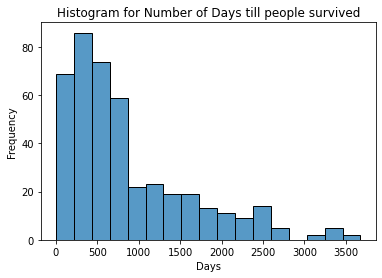

In [21]:
#Histogram for Number of Days till people survived
sns.histplot(data=clinical_Data['Survival'])

plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Histogram for Number of Days till people survived')

plt.show()

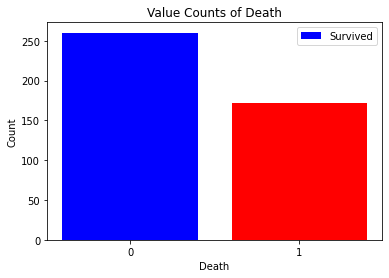

In [22]:
value_counts = clinical_Data["Death"].value_counts()

colors = ['blue', 'red']

plt.bar(value_counts.index, value_counts.values, color=colors)

plt.xticks([0, 1])

plt.xlabel("Death")
plt.ylabel("Count")
plt.title("Value Counts of Death")

legend_labels = ["Survived", "Deceased"]
plt.legend(legend_labels)
plt.show()


In [23]:
grouped_data = clinical_Data.groupby(['Death', 'gender']).size().unstack()
print(grouped_data)


gender  female  male
Death               
0.0         73   180
1.0         67   105


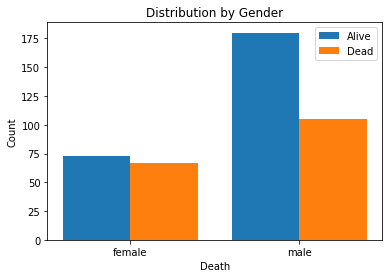

In [24]:
survived_data = (grouped_data.loc[0.0].values).tolist()
diceased_data = (grouped_data.loc[1.0].values).tolist()

x = np.arange(len(diceased_data))
width = 0.4

plt.bar(x - width/2, survived_data, width, label='Alive')
plt.bar(x + width/2, diceased_data, width, label='Dead')

plt.xlabel('Death')
plt.ylabel('Count')
plt.title('Distribution by Gender')

plt.xticks(x, grouped_data.columns)

plt.legend()

plt.show()

In [25]:
grouped_data = clinical_Data.groupby(['Death', 'pathologic_stage']).size().unstack()
print(grouped_data)

pathologic_stage  stage i  stage ii  stage iii  stage iiia  stage iiib  \
Death                                                                    
0.0                 137.0      63.0        2.0        30.0         5.0   
1.0                  57.0      35.0        4.0        40.0         4.0   

pathologic_stage  stage iiic  stage iv  stage iva  stage ivb  
Death                                                         
0.0                      4.0       NaN        1.0        NaN  
1.0                      6.0       3.0        NaN        2.0  


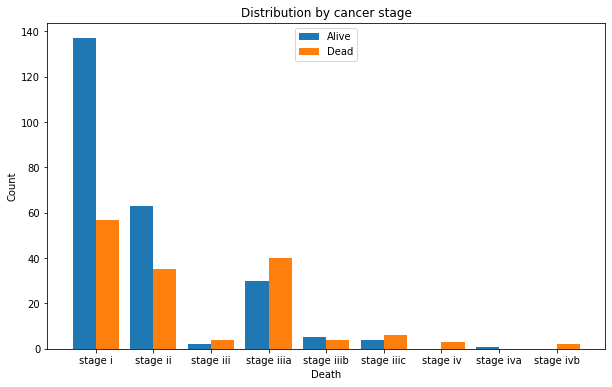

In [26]:
survived_data = grouped_data.loc[0.0].values.tolist()
deceased_data = grouped_data.loc[1.0].values.tolist()

x = np.arange(len(deceased_data))
width = 0.4

fig = plt.figure(figsize=(10, 6))
plt.bar(x - width/2, survived_data, width, label='Alive')
plt.bar(x + width/2, deceased_data, width, label='Dead')

plt.xlabel('Death')
plt.ylabel('Count')
plt.title('Distribution by cancer stage')

plt.xticks(x, grouped_data.columns)

plt.legend()

plt.show()

Most of the data is available for stage i and stage ii cancer. This is the reason why most of the data is available for class 0(surviving).

In [27]:
grouped_data = grouped_data.fillna(0)
grouped_data

pathologic_stage,stage i,stage ii,stage iii,stage iiia,stage iiib,stage iiic,stage iv,stage iva,stage ivb
Death,,,,,,,,,
0.0,137.0,63.0,2.0,30.0,5.0,4.0,0.0,1.0,0.0
1.0,57.0,35.0,4.0,40.0,4.0,6.0,3.0,0.0,2.0


In [28]:
grouped_data = clinical_Data.groupby(['Death', 'pathologic_stage']).size().unstack()

#print("......................................................")
filtered_data = clinical_Data[(clinical_Data['pathologic_stage'] == 'stage i') & (clinical_Data['Death'] == 0)]
filtered_data1 = clinical_Data[(clinical_Data['pathologic_stage'] == 'stage ii') & (clinical_Data['Death'] == 0)]
#print(filtered_data)
#print(".......................................................")
reduced_data = filtered_data.sample(n=57, random_state=42)
reduced_data1 = filtered_data1.sample(n=35, random_state=42)
# Update the clinical_Data DataFrame with the reduced samples
clinical_Data = clinical_Data.drop(filtered_data.index)  # Remove the filtered samples
clinical_Data = pd.concat([clinical_Data, reduced_data])  # Add the reduced samples back to the DataFrame
clinical_Data = clinical_Data.drop(filtered_data1.index)  # Remove the filtered samples
clinical_Data = pd.concat([clinical_Data, reduced_data1])  # Add the reduced samples back to the DataFrame
clinical_Data['pathologic_stage'] = clinical_Data['pathologic_stage'].replace(['stage iii','stage iiia', 'stage iiib', 'stage iiic'], 'stage iii')
clinical_Data['pathologic_stage'] = clinical_Data['pathologic_stage'].replace(['stage iv','stage iva', 'stage ivb'], 'stage iv')
#print(clinical_Data)
grouped_data = clinical_Data.groupby(['Death', 'pathologic_stage']).size().unstack()
print(grouped_data)

pathologic_stage  stage i  stage ii  stage iii  stage iv
Death                                                   
0.0                    57        35         41         1
1.0                    57        35         54         5


Samples for Tumor type i and ii are balanced. stage iii and stage iv data are merged

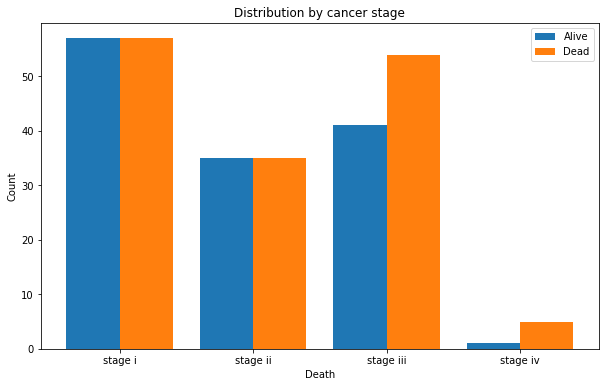

In [29]:
survived_data = grouped_data.loc[0.0].values.tolist()
deceased_data = grouped_data.loc[1.0].values.tolist()

x = np.arange(len(deceased_data))
width = 0.4

fig = plt.figure(figsize=(10, 6))
plt.bar(x - width/2, survived_data, width, label='Alive')
plt.bar(x + width/2, deceased_data, width, label='Dead')

plt.xlabel('Death')
plt.ylabel('Count')
plt.title('Distribution by cancer stage')

plt.xticks(x, grouped_data.columns)

plt.legend()

plt.show()

gender  female  male
Death               
0.0         47    98
1.0         67   105


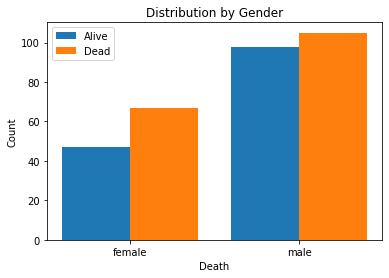

In [30]:
grouped_data = clinical_Data.groupby(['Death', 'gender']).size().unstack()
print(grouped_data)

survived_data = (grouped_data.loc[0.0].values).tolist()
diceased_data = (grouped_data.loc[1.0].values).tolist()

x = np.arange(len(diceased_data))
width = 0.4

plt.bar(x - width/2, survived_data, width, label='Alive')
plt.bar(x + width/2, diceased_data, width, label='Dead')

plt.xlabel('Death')
plt.ylabel('Count')
plt.title('Distribution by Gender')

plt.xticks(x, grouped_data.columns)

plt.legend()

plt.show()

Most of the alive data was coming from male patients from class 1 and class 2 for the surviving class.

Merging clinical and the other 3 datasets(mrna,mirna, mrthylaion) data for the survival anlysis later on. Doing it now because we will get different siginificant columns towards the end of every machine learning anlaysis. We can fetch the data for the columns of interest from this merged dataframe directly.

In [31]:
#NOTE - run this snippet only once/ read the file again if you want to run it again
g_exp = exp.copy()
g_exp.reset_index(inplace=True)
g_exp.rename(columns={'index': 'PatientID'}, inplace=True)
g_exp['PatientID'] = g_exp['PatientID'].str.replace('.', '-', regex=False)
g_exp = pd.merge(clinical_Data, g_exp, on='PatientID')

mi_rna = mirna.copy()
mi_rna.reset_index(inplace=True)
mi_rna.rename(columns={'index': 'PatientID'}, inplace=True)
mi_rna['PatientID'] = mi_rna['PatientID'].str.replace('.', '-', regex=False)
mi_rna = pd.merge(clinical_Data, mi_rna, on='PatientID')

meth = pd.DataFrame(np.log2(meth.values / (1 - meth.values)), columns=meth.columns, index=meth.index)
methyl = meth.copy()
methyl.reset_index(inplace=True)
methyl.rename(columns={'index': 'PatientID'}, inplace=True)
methyl['PatientID'] = methyl['PatientID'].str.replace('.', '-', regex=False)
methyl = pd.merge(clinical_Data, methyl, on='PatientID')

merged_data = pd.merge(g_exp, mi_rna, on=['PatientID', 'Survival', 'Death'])
merged_data.set_index('PatientID', inplace=True)
merged_data = pd.merge(merged_data, methyl, on=['PatientID', 'Survival', 'Death'])
merged_data.set_index('PatientID', inplace=True)


In [32]:
merged_data.shape

(305, 26630)

In [33]:
merged_data

,Survival,Death,PatientIDx_x,years_to_birth_x,vital_status_x,days_to_death_x,days_to_last_followup_x,tumor_tissue_site_x,pathologic_stage_x,pathology_T_stage_x,...,rs7660805,rs7746156,rs798149,rs845016,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367
PatientID,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.090260,4.574088,4.986558,-0.779994,0.079604,0.052294,0.240336,0.364626,-0.027894,-4.291783
TCGA-2Y-A9GS-01,724.0,1.0,tcga-2y-a9gs,58,1,724,NaN,liver,stage iv,t2,...,-0.992959,-0.235682,5.108706,3.817193,0.123514,-5.565543,0.430180,4.595687,-4.665199,-0.151536
TCGA-2Y-A9GT-01,1624.0,1.0,tcga-2y-a9gt,51,1,1624,NaN,liver,stage i,t1,...,0.066390,-0.214157,-5.742076,4.301920,0.258898,-5.281382,0.341113,4.856320,4.936181,4.207367
TCGA-2Y-A9GV-01,2532.0,1.0,tcga-2y-a9gv,54,1,2532,NaN,liver,stage i,t1,...,4.213599,4.510237,-5.932924,3.990511,0.402170,4.889835,0.108868,0.134046,0.037220,-4.693359
TCGA-2Y-A9GW-01,1271.0,1.0,tcga-2y-a9gw,64,1,1271,NaN,liver,stage i,t1,...,0.434825,4.810465,-5.525460,-4.354966,-5.584037,5.155990,0.419281,0.334974,5.086901,3.711484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ED-A5KG-01,854.0,0.0,tcga-ed-a5kg,60,0,NaN,854,liver,stage ii,t2,...,-4.780403,4.783279,-0.607080,-4.749953,0.001592,4.829256,4.085913,0.191372,-4.755376,-0.074092
TCGA-WX-AA46-01,756.0,0.0,tcga-wx-aa46,61,0,NaN,756,liver,stage ii,t2,...,0.398374,-0.156409,4.947756,-4.580844,5.126155,-0.146627,0.676968,0.225812,0.114283,-0.067660
TCGA-ZS-A9CE-01,1241.0,0.0,tcga-zs-a9ce,79,0,NaN,1241,liver,stage ii,t2,...,-3.419204,0.008065,-5.862900,3.085294,-5.953977,4.775321,0.599323,-0.454096,0.020579,0.297164


# Analysing significant columns obtained from machine learning models

Among the machine learning models applied to the data after reducing the columns using logistic regression, SVM exhibited the best results.

In [34]:
svm_logreg_results = pd.read_csv('C:/Users/shubh/Downloads/liver/imp_features_svm_logreg.csv')    #edit it and save the data from feature_import variable that was used in svm classifier for data obtained by logreg ml
svm_logreg_results.shape
svm_logreg_results

,feature,importance
0,X..100133144,0.009777
1,ABP1.26,0.007423
2,ACOXL.55289,0.021113
3,ACSM4.341392,0.040499
4,ADAMTS5.11096,0.030658
...,...,...
369,hsa.mir.642b,0.018082
370,hsa.mir.658,0.029001
371,hsa.mir.7.2,0.027147
372,hsa.mir.890,0.032150


Text(0.5, 1.0, 'Feature Importance Scores for SVM_LogReg')

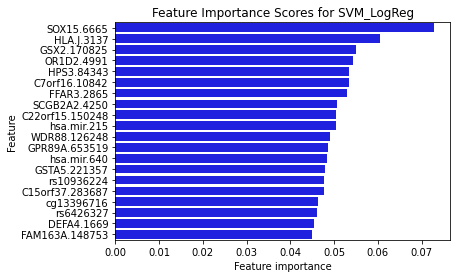

In [35]:
svm_logreg_results.columns = ['feature', 'importance']
svm_logreg_results.sort_values('importance', ascending=False, inplace=True)
sns.barplot(y='feature', x='importance', data=svm_logreg_results.head(20), color='blue')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Feature Importance Scores for SVM_LogReg')

Among the machine learning models applied to the data after reducing the columns using differential analysis, Gradient Boost algorithm exhibited the best results.

In [36]:
gb_diff_results = pd.read_csv('C:/Users/shubh/Downloads/imp_features_gb_diff.csv', index_col = 0)   #edit it and save the data from feature_import variable that was used in gradient boost classifier for data obtained by differentially expressed data
gb_diff_results

,feature,importance
146,NCRNA00162.378825,0.063739
127,KRTAP1.1.81851,0.044053
97,FRMD1.79981,0.041237
89,EPO.2056,0.035007
179,SAGE1.55511,0.030164
...,...,...
57,CCL23.6368,0.000000
75,CXCL14.9547,0.000000
126,KRT85.3891,0.000000
27,hsa.mir.466,0.000000


Text(0.5, 1.0, 'Feature Importance Scores for Gradient Boost_diff')

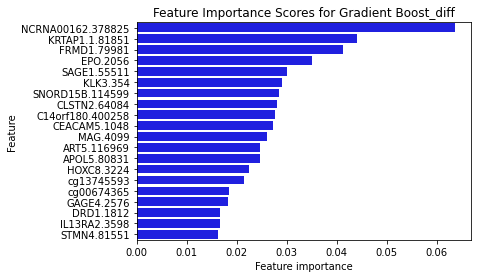

In [37]:
gb_diff_results.columns = ['feature', 'importance']
gb_diff_results.sort_values('importance', ascending=False, inplace=True)
sns.barplot(y='feature', x='importance', data=gb_diff_results.head(20), color='blue')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Feature Importance Scores for Gradient Boost_diff')


Common set of data among the most significant data points by both the algorithms

In [38]:
common = set(svm_logreg_results.iloc[:, 0]) & set(gb_diff_results.iloc[:, 0])


In [39]:
common

{'ABP1.26',
 'CYP26B1.56603',
 'FRMD1.79981',
 'GDNF.2668',
 'GRM8.2918',
 'MGAT4C.25834',
 'PCDHGB2.56103',
 'STMN4.81551',
 'cg00674365',
 'cg04223671',
 'cg08435683',
 'cg08979352',
 'cg12036633',
 'cg14453201',
 'cg14619259',
 'cg15415945',
 'cg26452868'}

# Preparing the data for Survival Analysis

##### 1\. on significant features obtained by SVM which was run on data reduced by Log Regression

In [40]:
#features with importance score >0.025, arbitrarily chosen after analysing the bar plot
filtered_features = svm_logreg_results[svm_logreg_results.iloc[:, 1] > 0.025] 
filtered_features.shape

(133, 2)

In [41]:
#get all the information for the significant columns directly from the merged data
filt_cols = merged_data[filtered_features.iloc[:, 0].tolist()]
filt_cols.shape

(305, 133)

In [42]:
#Remove columns with variance less than 1
num_Data=pd.DataFrame(filt_cols[filt_cols.select_dtypes(include=[np.number]).columns])
low_variance_columns=num_Data.columns[num_Data.var() <= 1] #checking all columns that have varience less than 1
filt_cols.drop(low_variance_columns, axis=1, inplace=True) #drop dolumns with low varience
filt_cols.shape

C:\Users\shubh\AppData\Local\Temp\ipykernel_18124\1706613807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_cols.drop(low_variance_columns, axis=1, inplace=True) #drop dolumns with low varience


(305, 84)

columns reduced from 133 to 84

In [43]:
surv_Data = pd.merge(filt_cols, clinical_Data, left_index=True, right_index=True, how="left") #merge the columns data with clincial data
surv_Data.head()

,SOX15.6665,HLA.J.3137,HPS3.84343,FFAR3.2865,SCGB2A2.4250,C22orf15.150248,hsa.mir.215,WDR88.126248,GPR89A.653519,rs10936224,...,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race,ethnicity
PatientID,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01,9.1220,22.1339,844.0007,5.2126,0.0000,3.2579,901.021507,1.3031,1048.3792,1.959660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-2Y-A9GS-01,9.3642,10.8576,2160.7294,0.4929,0.0000,20.6999,68.543396,6.9000,832.4298,-3.748829,...,t2,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,hispanic or latino
TCGA-2Y-A9GT-01,5.3800,15.5212,619.7176,51.1096,0.8967,2.6900,792.033759,3.5866,863.4835,-4.156016,...,t1,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GV-01,0.0000,20.8460,735.4569,8.4602,0.0000,5.9222,132.376210,2.5381,714.8900,-3.738274,...,t1,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GW-01,5.3640,27.1877,823.7241,1.5326,0.0000,6.1303,43.007260,0.0000,1107.2797,-0.226478,...,t1,n0,mx,male,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino


##### Taking care of the null values

In [44]:
surv_Data.isna().sum()

SOX15.6665            0
HLA.J.3137            0
HPS3.84343            0
FFAR3.2865            0
SCGB2A2.4250          0
                     ..
radiation_therapy    28
histological_type     9
residual_tumor       15
race                 19
ethnicity            27
Length: 103, dtype: int64

In [45]:
print(surv_Data.iloc[:, -20:].isna().sum())


cg23212796                                0
Survival                                  6
Death                                     6
PatientIDx                                9
years_to_birth                           13
vital_status                              9
days_to_death                           150
days_to_last_followup                   121
tumor_tissue_site                         9
pathologic_stage                         39
pathology_T_stage                        10
pathology_N_stage                        11
pathology_M_stage                         9
gender                                    9
date_of_initial_pathologic_diagnosis     11
radiation_therapy                        28
histological_type                         9
residual_tumor                           15
race                                     19
ethnicity                                27
dtype: int64


In [46]:
surv_Data = surv_Data.dropna(subset=['Death','years_to_birth']) #since these columns are important for the analysis

surv_Data = surv_Data.drop(['PatientIDx'], axis=1) #we already have this data as column id

surv_Data.loc[surv_Data['ethnicity'] == 'hispanic or latino', 'race'] = 'white (hispanic or latino)' #one column will suffice
surv_Data = surv_Data.drop(['ethnicity'], axis=1)


surv_Data = surv_Data.drop(['vital_status'], axis=1) #same as Survival

col_na = ['pathologic_stage', 'pathology_T_stage', 'pathology_N_stage', 'pathology_M_stage', 'date_of_initial_pathologic_diagnosis', 'residual_tumor', 'radiation_therapy', 'histological_type', 'race', 'tumor_tissue_site']
surv_Data[col_na] = surv_Data[col_na].fillna(0) #the values inside these variables will be dealt with later

print(surv_Data.iloc[:, -20:].isna().sum())
surv_Data.shape


YIPF1.54432                               0
MYBPC1.4604                               0
ZNF876P.642280                            0
cg23212796                                0
Survival                                  0
Death                                     0
years_to_birth                            0
days_to_death                           136
days_to_last_followup                   110
tumor_tissue_site                         0
pathologic_stage                          0
pathology_T_stage                         0
pathology_N_stage                         0
pathology_M_stage                         0
gender                                    0
date_of_initial_pathologic_diagnosis      0
radiation_therapy                         0
histological_type                         0
residual_tumor                            0
race                                      0
dtype: int64


(288, 100)

days_to_death and days_to_last_followup are important for finding the censoring data

In [47]:
combination_1 = ((surv_Data['days_to_death'].notnull()) & (surv_Data['days_to_last_followup'].isnull())).sum()
combination_2 = ((surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].notnull())).sum()
combination_3 = ((surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].isnull())).sum() #both null
combination_4 = ((surv_Data['days_to_death'].notnull()) & (surv_Data['days_to_last_followup'].notnull())).sum() #both has data

print('Combination 1 = days_to_death is filled, days_to_last_followup is null\nCombination 2 = days_to_death is null, days_to_last_followup is filled\nCombination 3 = Both are null\nCombination 4 = Both are filled')
# Print the frequencies
print("\nCombination 1 frequency:", combination_1)
print("Combination 2 frequency:", combination_2)
print("Combination 3 frequency:", combination_3)
print("Combination 4 frequency:", combination_4)

Combination 1 = days_to_death is filled, days_to_last_followup is null
Combination 2 = days_to_death is null, days_to_last_followup is filled
Combination 3 = Both are null
Combination 4 = Both are filled

Combination 1 frequency: 110
Combination 2 frequency: 136
Combination 3 frequency: 0
Combination 4 frequency: 42


In [48]:

surv_Data.loc[(surv_Data['days_to_death'].notnull()) & (surv_Data['days_to_last_followup'].notnull())].iloc[:, -20:]


,YIPF1.54432,MYBPC1.4604,ZNF876P.642280,cg23212796,Survival,Death,years_to_birth,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,,,,,,
TCGA-4R-AA8I-01,1391.4835,3.4341,11.6758,-1.589425,262.0,1.0,66,262,216,liver,stage ii,t2,nx,mx,male,2013,no,hepatocellular carcinoma,r0,white
TCGA-BC-A217-01,1796.5298,0.9986,64.9107,-2.004827,1397.0,1.0,75,1397,421,liver,stage ii,t2,nx,m0,female,2010,no,hepatocellular carcinoma,r0,white
TCGA-BC-A5W4-01,1765.0216,0.0000,1.6581,4.404296,547.0,1.0,69,547,289,liver,stage iii,t3a,nx,m0,male,2012,no,hepatocellular carcinoma,r1,white
TCGA-CC-5258-01,752.4988,0.4760,21.8943,4.466685,129.0,1.0,48,129,0,liver,stage ii,t2,n0,m0,male,2010,no,hepatocellular carcinoma,rx,asian
TCGA-CC-5260-01,613.8350,0.0000,11.2576,4.340190,87.0,1.0,61,87,0,liver,stage iii,t4,n0,m0,female,2010,no,hepatocellular carcinoma,rx,asian
TCGA-CC-5261-01,620.2879,1.3708,2.0562,4.535484,97.0,1.0,44,97,12,liver,stage ii,t2,n0,m0,male,2010,no,hepatocellular carcinoma,rx,asian
TCGA-CC-5262-01,1852.5506,0.0000,9.4325,0.968736,103.0,1.0,67,103,0,liver,stage iii,t4,n0,m0,male,2010,no,hepatocellular carcinoma,0,asian
TCGA-CC-5264-01,958.9540,9.2685,13.5717,-1.621605,102.0,1.0,71,102,0,liver,stage iii,t3,n0,m0,male,2010,no,hepatocellular carcinoma,rx,asian
TCGA-CC-A1HT-01,1416.5650,11.9290,11.3867,1.408522,101.0,1.0,50,101,0,liver,stage iii,t3,n0,m0,male,2010,no,hepatocellular carcinoma,0,asian


data for all the above columns are for the patients who died

In [49]:
surv_Data.loc[(surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].notnull())].iloc[:, -20:]


,YIPF1.54432,MYBPC1.4604,ZNF876P.642280,cg23212796,Survival,Death,years_to_birth,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,,,,,,
TCGA-2Y-A9H0-01,1411.3231,26.9002,31.2793,-1.643057,3675.0,0.0,49,NaN,3675,liver,stage iii,t3,n0,m0,male,2004,no,hepatocellular carcinoma,r0,white (hispanic or latino)
TCGA-3K-AAZ8-01,1195.2079,2.8189,3.3827,-1.908852,396.0,0.0,65,NaN,396,liver,stage iii,t3b,nx,mx,male,2013,no,hepatocellular carcinoma,rx,black or african american
TCGA-5R-AA1D-01,801.6586,0.6911,13.1306,4.235659,449.0,0.0,17,NaN,449,liver,stage iii,t3a,n0,m0,female,2013,yes,hepatocellular carcinoma,r0,white
TCGA-BC-4073-01,1098.8106,35.6816,30.1921,-0.258471,849.0,0.0,73,NaN,849,liver,stage iii,t3,n0,mx,male,2009,no,hepatocellular carcinoma,r1,white
TCGA-BC-A216-01,1669.8930,3.5660,6.1131,-1.786695,1351.0,0.0,62,NaN,1351,liver,stage iii,t3,nx,m0,female,2008,no,hepatocellular carcinoma,r0,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ED-A5KG-01,733.2325,0.5043,12.1029,4.313663,854.0,0.0,60,NaN,854,liver,stage ii,t2,n0,m0,female,2012,no,hepatocellular carcinoma,r0,asian
TCGA-WX-AA46-01,714.7147,0.0000,4.2042,3.801507,756.0,0.0,61,NaN,756,liver,stage ii,t2,nx,mx,male,2012,no,hepatocellular carcinoma,r0,white
TCGA-ZS-A9CE-01,1670.1313,1.6411,11.4880,-2.987919,1241.0,0.0,79,NaN,1241,liver,stage ii,t2,nx,mx,female,2011,no,hepatocellular carcinoma,r0,white


data for all the above columns are for the patients who were still alive but the data for the future was not available. nor it was specified if they made recovery. this will be our censored data and will be used for the anlaysis later on to check how many days did the proceed to live.

In [50]:
rows_Combination3 = surv_Data.loc[(surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].notnull())]
count = (rows_Combination3['Death'] == 0).sum()
print(count)

136


Combination 1 and Combination 4, Death = 1;     
Combination 3, Death = 0

In [51]:
surv_Data.iloc[:, -13:]

,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,
TCGA-2Y-A9GS-01,724,NaN,liver,stage iv,t2,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white (hispanic or latino)
TCGA-2Y-A9GT-01,1624,NaN,liver,stage i,t1,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white
TCGA-2Y-A9GV-01,2532,NaN,liver,stage i,t1,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white
TCGA-2Y-A9GW-01,1271,NaN,liver,stage i,t1,n0,mx,male,2007,no,hepatocellular carcinoma,r0,white
TCGA-2Y-A9GY-01,757,NaN,liver,stage ii,t2,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ED-A5KG-01,NaN,854,liver,stage ii,t2,n0,m0,female,2012,no,hepatocellular carcinoma,r0,asian
TCGA-WX-AA46-01,NaN,756,liver,stage ii,t2,nx,mx,male,2012,no,hepatocellular carcinoma,r0,white
TCGA-ZS-A9CE-01,NaN,1241,liver,stage ii,t2,nx,mx,female,2011,no,hepatocellular carcinoma,r0,white


Refining the clinical data. Making every string value into a number since the data is categorical and more than that survival aanlsysis only accepts nmerical data.

In [52]:
surv_Data['Death'].value_counts()

1.0    152
0.0    136
Name: Death, dtype: int64

Imbalance ratio is not severe, is close to 1. We will continue without balancing the data

In [53]:
surv_Data['tumor_tissue_site'].value_counts()

liver    288
Name: tumor_tissue_site, dtype: int64

can be dropped

In [54]:
surv_Data.drop('tumor_tissue_site', axis=1, inplace=True)

In [55]:
surv_Data['pathologic_stage'].value_counts()

stage i      103
stage iii     87
stage ii      63
0             29
stage iv       6
Name: pathologic_stage, dtype: int64

In [56]:
surv_Data['pathology_T_stage'].value_counts()

t1     116
t2      70
t3      46
t3a     29
t4      16
t3b      7
tx       1
0        1
t2a      1
t2b      1
Name: pathology_T_stage, dtype: int64

In [57]:
surv_Data['pathology_M_stage'].value_counts()

m0    203
mx     81
m1      4
Name: pathology_M_stage, dtype: int64

In [58]:
surv_Data['pathology_N_stage'].value_counts()

n0    190
nx     91
n1      5
0       2
Name: pathology_N_stage, dtype: int64

In [59]:
surv_Data['gender'].value_counts()

male      186
female    102
Name: gender, dtype: int64

In [60]:
surv_Data['date_of_initial_pathologic_diagnosis'].value_counts()

2013    58
2012    37
2011    36
2010    26
2008    24
2007    17
2009    15
2005    12
2002    11
2006    10
1998     8
2003     7
2000     6
2001     5
1999     5
1996     3
2004     3
1995     2
0        2
1997     1
Name: date_of_initial_pathologic_diagnosis, dtype: int64

In [61]:
med = surv_Data.loc[surv_Data['date_of_initial_pathologic_diagnosis'] != 0, 'date_of_initial_pathologic_diagnosis'].median()
surv_Data['date_of_initial_pathologic_diagnosis'].replace(0, med, inplace=True)
surv_Data['date_of_initial_pathologic_diagnosis'].value_counts()

2013      58
2012      37
2011      36
2010      26
2008      24
2007      17
2009      15
2005      12
2002      11
2006      10
1998       8
2003       7
2000       6
2001       5
1999       5
1996       3
2004       3
1995       2
2010.0     2
1997       1
Name: date_of_initial_pathologic_diagnosis, dtype: int64

In [62]:
surv_Data['radiation_therapy'].value_counts()

no     266
0       16
yes      6
Name: radiation_therapy, dtype: int64

In [63]:
surv_Data['histological_type'].value_counts()

hepatocellular carcinoma            283
hepatocholangiocarcinoma (mixed)      5
Name: histological_type, dtype: int64

In [64]:
surv_Data['residual_tumor'].value_counts()

r0    249
rx     16
r1     15
0       6
r2      2
Name: residual_tumor, dtype: int64

In [65]:
surv_Data['race'].value_counts()

white                               142
asian                               108
black or african american            18
white (hispanic or latino)           10
0                                     9
american indian or alaska native      1
Name: race, dtype: int64

In [66]:
stage_mapping = {
    'stage i': 1,
    'stage ii': 2,
    'stage iii': 3,
    'stage iv': 4}

t_mapping = {
    't1': 1,
    't2': 2,
    't2a': 2.1,
    't2b': 2.2,
    't3': 3,
    't3a': 3.1,
    't3b': 3.2,
    't4': 4,
    'tx': 0}

n_mapping = {
    'n0': 0.1,
    'n1': 1,
    'n2': 2,
    'nx': 0}  


m_mapping = {
    'm0': 2,
    'm1': 1,
    'mx': 0}

gender_mapping = {
    'female': 1,
    'male': 2}

rad_th = {
    'no':1,
    'yes':2}

residual_t = {
    'r0':0.1,
    'rx':0,
    'r1':1,
    'r2':2,
}

hist_type = {
    'hepatocellular carcinoma' :1,
'hepatocholangiocarcinoma (mixed)':2}

race_mapping = {
    'white' :1,
    'asian' :2,
    'black or african american':3,
    'white (hispanic or latino)':4,
    'american indian or alaska native':5
}

surv_Data['pathologic_stage'] = surv_Data['pathologic_stage'].replace(stage_mapping)
surv_Data['pathology_T_stage'] = surv_Data['pathology_T_stage'].replace(t_mapping)
surv_Data['pathology_N_stage'] = surv_Data['pathology_N_stage'].replace(n_mapping)
surv_Data['pathology_M_stage'] = surv_Data['pathology_M_stage'].replace(m_mapping)
surv_Data['gender'] = surv_Data['gender'].replace(gender_mapping)
surv_Data['radiation_therapy'] = surv_Data['radiation_therapy'].replace(rad_th)
surv_Data['residual_tumor'] = surv_Data['residual_tumor'].replace(residual_t)
surv_Data['histological_type'] = surv_Data['histological_type'].replace(hist_type)
surv_Data['race'] = surv_Data['race'].replace(race_mapping)
print(surv_Data.iloc[:, -20:].isna().sum())
surv_Data.shape

ALPP.250                                  0
YIPF1.54432                               0
MYBPC1.4604                               0
ZNF876P.642280                            0
cg23212796                                0
Survival                                  0
Death                                     0
years_to_birth                            0
days_to_death                           136
days_to_last_followup                   110
pathologic_stage                          0
pathology_T_stage                         0
pathology_N_stage                         0
pathology_M_stage                         0
gender                                    0
date_of_initial_pathologic_diagnosis      0
radiation_therapy                         0
histological_type                         0
residual_tumor                            0
race                                      0
dtype: int64


(288, 99)

In [67]:
#Separate Censored data for later where we predict median number of days left to live 
Censored_data = surv_Data.loc[(surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].notnull())]

In [68]:
#Drop columns days_to_death and days_to_last_followup for survival analysis. We have Survical column which has combination of that data in it
surv_Data = surv_Data.drop(['days_to_death','days_to_last_followup'], axis=1)


# Survival Analysis

C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 288 total observations, 136 right-censored observations>
             duration col = 'Survival'
                event col = 'Death'
      baseline estimation = breslow
   number of observations = 288
number of events observed = 152
   partial log-likelihood = -712.52
         time fit was run = 2023-07-20 22:29:15 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                    
SOX15.6665                            -0.03       0.97       0.05            -0.12             0.06                 0.88                 1.06
HLA.J.3137                             0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
HPS3.84343                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
FFAR3.2865                             0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04
SCGB2A2.4250                           0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
C22orf15.150248                       -0.05       0.95       0.05            -0.14             0.04                 0.87                 1.04
hsa.mir.215                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
WDR88.126248                          -0.03       0.97       0.05            -0.13             0.08                 0.88                 1.08
GPR89A.653519                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
rs10936224                             0.05       1.05       0.06            -0.06             0.17                 0.94                 1.18
C15orf37.283687                        0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
cg13396716                             0.16       1.17       0.10            -0.04             0.36                 0.96                 1.43
rs6426327                             -0.03       0.97       0.05            -0.13             0.07                 0.88                 1.07
DEFA4.1669                            -0.16       0.85       0.10            -0.35             0.04                 0.70                 1.04
FAM163A.148753                         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
RPL21P44.402176                       -0.24       0.79       0.15            -0.54             0.06                 0.58                 1.07
hsa.mir.129.1                          0.02       1.02       0.04            -0.06             0.10                 0.94                 1.10
VWA3A.146177                           0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
KRTAP5.8.57830                         0.12       1.13       0.09            -0.05             0.29                 0.95                 1.34
TAF3.83860                             0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
rs5926356                              0.03       1.03       0.06            -0.09             0.14                 0.91                 1.15
PEX11B.8799                           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MSMP.692094                           -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
rs5931272                              0.05       1.05       0.04            -0.03       

<AxesSubplot:xlabel='log(HR) (95% CI)'>

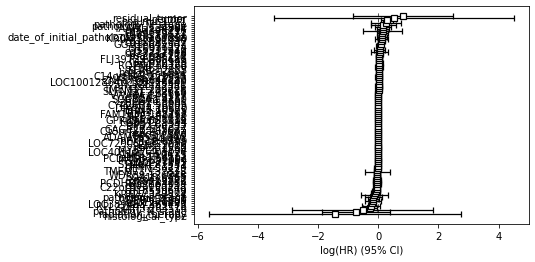

In [69]:
cph = CoxPHFitter()
cph.fit(surv_Data, duration_col='Survival', event_col='Death')
cph.print_summary()
cph.plot()

In [70]:
# hazard ratios + CI
hazard_ratios = cph.summary['exp(coef)']
ci_lower = cph.summary['exp(coef) lower 95%']
ci_upper = cph.summary['exp(coef) upper 95%']

results = pd.DataFrame({
    'Variable': hazard_ratios.index,
    'Hazard Ratio': hazard_ratios.values,
    'CI Lower': ci_lower.values,
    'CI Upper': ci_upper.values
})
print(results)

                                Variable  Hazard Ratio  CI Lower   CI Upper
0                             SOX15.6665      0.968444  0.884587   1.060251
1                             HLA.J.3137      1.003540  0.992554   1.014649
2                             HPS3.84343      1.000248  0.999591   1.000905
3                             FFAR3.2865      1.021809  0.999451   1.044667
4                           SCGB2A2.4250      1.003389  0.990590   1.016353
..                                   ...           ...       ...        ...
90  date_of_initial_pathologic_diagnosis      1.133869  1.036247   1.240687
91                     radiation_therapy      0.476845  0.155872   1.458762
92                     histological_type      0.236838  0.003649  15.371748
93                        residual_tumor      2.283609  0.436356  11.950940
94                                  race      0.974682  0.638336   1.488251

[95 rows x 4 columns]


In [71]:
#top features
col_coef = cph.summary['exp(coef)'].abs().sort_values(ascending=False)
print("\nSorted features based on hazard ratios:")
print(col_coef.head(50))


Sorted features based on hazard ratios:
covariate
residual_tumor                          2.283609
gender                                  1.662877
hsa.mir.1271                            1.324160
pathology_T_stage                       1.293304
pathology_M_stage                       1.189245
TAAR1.134864                            1.181764
cg13396716                              1.172802
cg23696472                              1.159889
cg09173621                              1.146172
date_of_initial_pathologic_diagnosis    1.133869
KRTAP5.8.57830                          1.130192
cg12691230                              1.116755
cg15565032                              1.103892
GGT8P.645367                            1.085647
rs10936224                              1.054769
rs5931272                               1.049566
cg19212949                              1.048104
cg23212796                              1.044350
hsa.mir.212                             1.041808
ALPP.250          

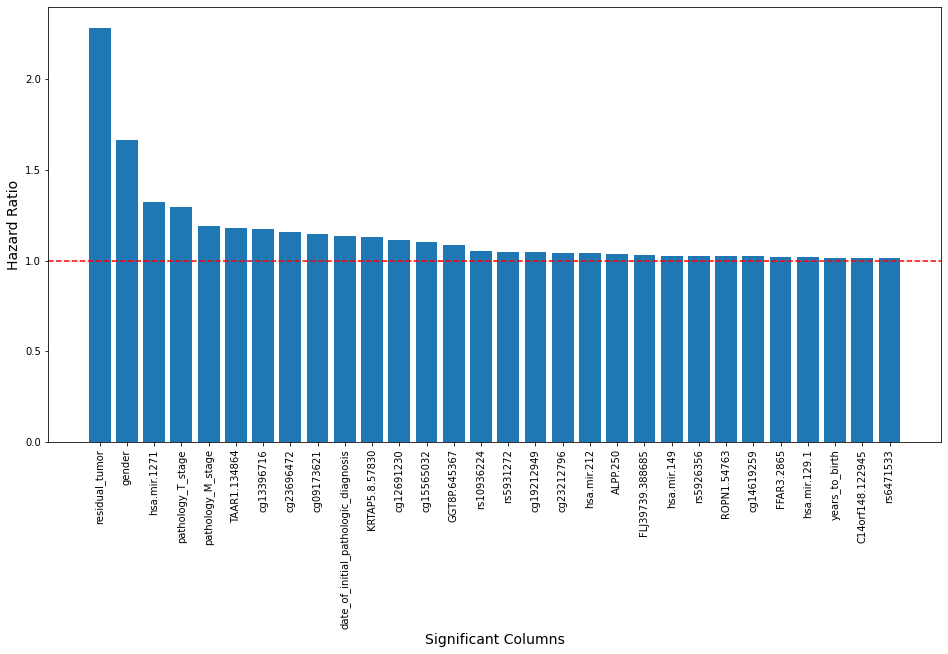

In [72]:
top_50_hazard_ratios = col_coef.head(30)
plt.figure(figsize=(16, 8))
plt.bar(top_50_hazard_ratios.index, top_50_hazard_ratios)
plt.xticks(rotation=90)
plt.axhline(y=1, color='red', linestyle='--', label='Hazard Ratio = 1')
plt.xlabel('Significant Columns', fontsize=14)  
plt.ylabel('Hazard Ratio', fontsize=14)  

plt.show()

Analysing KM plots

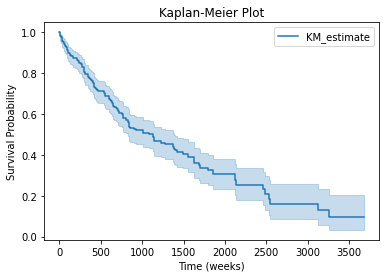

In [73]:
#Kaplan meier plot
kmf = KaplanMeierFitter()
kmf.fit(surv_Data['Survival'], event_observed=surv_Data['Death'])
kmf.plot()

plt.title('Kaplan-Meier Plot')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')

plt.show()


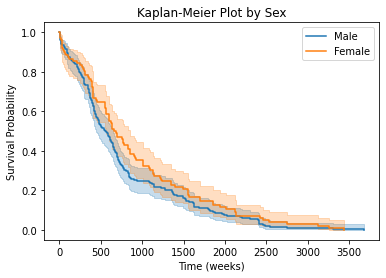

In [74]:
male_survival = surv_Data[surv_Data['gender'] == 2]['Survival']
male_event = surv_Data[surv_Data['gender'] == 2]['Survival'].apply(lambda x: 0 if x == 1 else 1)

female_survival = surv_Data[surv_Data['gender'] == 1]['Survival']
female_event = surv_Data[surv_Data['gender'] == 1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

kmf_male = KaplanMeierFitter()
kmf_male.fit(male_survival, event_observed=male_event)

kmf_female = KaplanMeierFitter()
kmf_female.fit(female_survival, event_observed=female_event)

plt.figure()
kmf_male.plot(label='Male')
kmf_female.plot(label='Female')

plt.title('Kaplan-Meier Plot by Sex')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')

plt.legend()
plt.show()

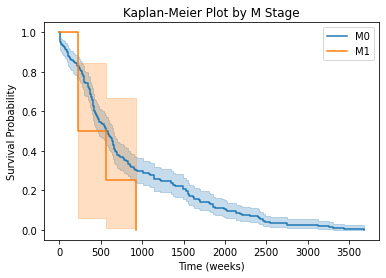

In [75]:
m0_survival = surv_Data[surv_Data['pathology_M_stage'] == 2]['Survival']
m0_event = surv_Data[surv_Data['pathology_M_stage'] == 2]['Survival'].apply(lambda x: 0 if x == 1 else 1)

m1_survival = surv_Data[surv_Data['pathology_M_stage'] == 1]['Survival']
m1_event = surv_Data[surv_Data['pathology_M_stage'] == 1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

kmf_m0 = KaplanMeierFitter()
kmf_m0.fit(m0_survival, event_observed=m0_event)

kmf_m1 = KaplanMeierFitter()
kmf_m1.fit(m1_survival, event_observed=m1_event)

plt.figure()
kmf_m0.plot(label='M0')
kmf_m1.plot(label='M1')

plt.title('Kaplan-Meier Plot by M Stage')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')

plt.legend()
plt.show()

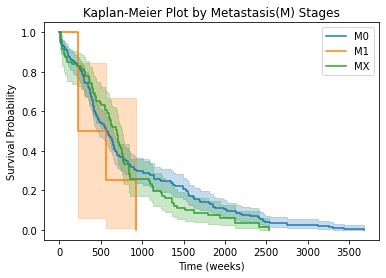

In [76]:
m0_survival = surv_Data[surv_Data['pathology_M_stage'] == 2]['Survival']
m0_event = surv_Data[surv_Data['pathology_M_stage'] == 2]['Survival'].apply(lambda x: 0 if x == 1 else 1)

m1_survival = surv_Data[surv_Data['pathology_M_stage'] == 1]['Survival']
m1_event = surv_Data[surv_Data['pathology_M_stage'] == 1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

mx_survival = surv_Data[surv_Data['pathology_M_stage'] == 0]['Survival']
mx_event = surv_Data[surv_Data['pathology_M_stage'] == 0]['Survival'].apply(lambda x: 0 if x == 1 else 1)

kmf_m0 = KaplanMeierFitter()
kmf_m0.fit(m0_survival, event_observed=m0_event)

kmf_m1 = KaplanMeierFitter()
kmf_m1.fit(m1_survival, event_observed=m1_event)

kmf_mx = KaplanMeierFitter()
kmf_mx.fit(mx_survival, event_observed=mx_event)

plt.figure()
kmf_m0.plot(label='M0')
kmf_m1.plot(label='M1')
kmf_mx.plot(label='MX')

plt.title('Kaplan-Meier Plot by Metastasis(M) Stages')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')

plt.legend()
plt.show()

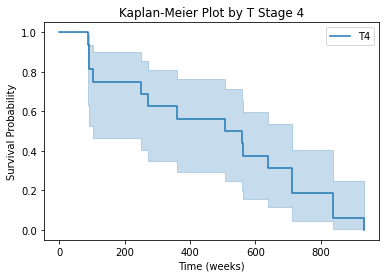

In [77]:
t1_survival = surv_Data[surv_Data['pathology_T_stage'] == 1]['Survival']
t1_event = surv_Data[surv_Data['pathology_T_stage'] == 1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t2_survival = surv_Data[surv_Data['pathology_T_stage'] == 2]['Survival']
t2_event = surv_Data[surv_Data['pathology_T_stage'] == 2]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t2a_survival = surv_Data[surv_Data['pathology_T_stage'] == 2.1]['Survival']
t2a_event = surv_Data[surv_Data['pathology_T_stage'] == 2.1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t2b_survival = surv_Data[surv_Data['pathology_T_stage'] == 2.2]['Survival']
t2b_event = surv_Data[surv_Data['pathology_T_stage'] == 2.2]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t3_survival = surv_Data[surv_Data['pathology_T_stage'] == 3]['Survival']
t3_event = surv_Data[surv_Data['pathology_T_stage'] == 3]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t3a_survival = surv_Data[surv_Data['pathology_T_stage'] == 3.1]['Survival']
t3a_event = surv_Data[surv_Data['pathology_T_stage'] == 3.1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t3b_survival = surv_Data[surv_Data['pathology_T_stage'] == 3.2]['Survival']
t3b_event = surv_Data[surv_Data['pathology_T_stage'] == 3.2]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t4_survival = surv_Data[surv_Data['pathology_T_stage'] == 4]['Survival']
t4_event = surv_Data[surv_Data['pathology_T_stage'] == 4]['Survival'].apply(lambda x: 0 if x == 1 else 1)

kmf_t1 = KaplanMeierFitter()
kmf_t1.fit(t1_survival, event_observed=t1_event)

kmf_t2 = KaplanMeierFitter()
kmf_t2.fit(t2_survival, event_observed=t2_event)

kmf_t2a = KaplanMeierFitter()
kmf_t2a.fit(t2a_survival, event_observed=t2a_event)

kmf_t2b = KaplanMeierFitter()
kmf_t2b.fit(t2b_survival, event_observed=t2b_event)

kmf_t3 = KaplanMeierFitter()
kmf_t3.fit(t3_survival, event_observed=t3_event)

kmf_t3a = KaplanMeierFitter()
kmf_t3a.fit(t3a_survival, event_observed=t3a_event)

kmf_t3b = KaplanMeierFitter()
kmf_t3b.fit(t3b_survival, event_observed=t3b_event)

kmf_t4 = KaplanMeierFitter()
kmf_t4.fit(t4_survival, event_observed=t4_event)


plt.figure()
kmf_t4.plot(label='T4')

plt.title('Kaplan-Meier Plot by T Stage 4')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')

plt.legend()
plt.show()

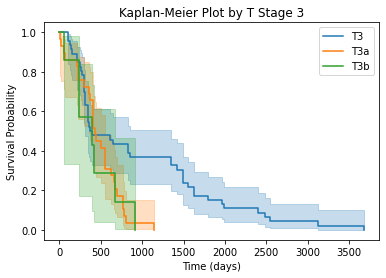

In [78]:


kmf_t3.plot(label='T3')
kmf_t3a.plot(label='T3a')
kmf_t3b.plot(label='T3b')

plt.title('Kaplan-Meier Plot by T Stage 3')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')

plt.legend()
plt.show()

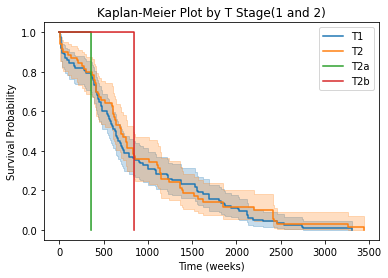

In [79]:


kmf_t1.plot(label='T1')
kmf_t2.plot(label='T2')
kmf_t2a.plot(label='T2a')
kmf_t2b.plot(label='T2b')

plt.title('Kaplan-Meier Plot by T Stage(1 and 2)')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')

plt.legend()
plt.show()

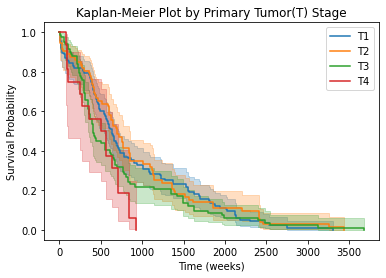

In [80]:
t_mapping = {
    't1': 1,
    't2': 2,
    't3': 3,
    't4': 4,
}

surv_Data['pathology_T_stage'] = surv_Data['pathology_T_stage'].replace(t_mapping)
surv_Data['pathology_T_stage'] = surv_Data['pathology_T_stage'].replace({2.1: 2, 2.2: 2, 3.1: 3, 3.2: 3})

t1_survival = surv_Data[surv_Data['pathology_T_stage'] == 1]['Survival']
t1_event = surv_Data[surv_Data['pathology_T_stage'] == 1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t2_survival = surv_Data[surv_Data['pathology_T_stage'] == 2]['Survival']
t2_event = surv_Data[surv_Data['pathology_T_stage'] == 2]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t3_survival = surv_Data[surv_Data['pathology_T_stage'] == 3]['Survival']
t3_event = surv_Data[surv_Data['pathology_T_stage'] == 3]['Survival'].apply(lambda x: 0 if x == 1 else 1)

t4_survival = surv_Data[surv_Data['pathology_T_stage'] == 4]['Survival']
t4_event = surv_Data[surv_Data['pathology_T_stage'] == 4]['Survival'].apply(lambda x: 0 if x == 1 else 1)

kmf_t1 = KaplanMeierFitter()
kmf_t1.fit(t1_survival, event_observed=t1_event)

kmf_t2 = KaplanMeierFitter()
kmf_t2.fit(t2_survival, event_observed=t2_event)

kmf_t3 = KaplanMeierFitter()
kmf_t3.fit(t3_survival, event_observed=t3_event)

kmf_t4 = KaplanMeierFitter()
kmf_t4.fit(t4_survival, event_observed=t4_event)

plt.figure()
kmf_t1.plot(label='T1')
kmf_t2.plot(label='T2')
kmf_t3.plot(label='T3')
kmf_t4.plot(label='T4')

plt.title('Kaplan-Meier Plot by Primary Tumor(T) Stage')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

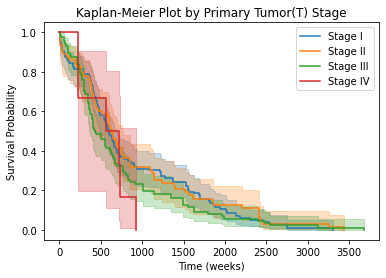

In [81]:
stage1_survival = surv_Data[surv_Data['pathologic_stage'] == 1]['Survival']
stage1_event = surv_Data[surv_Data['pathologic_stage'] == 1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

stage2_survival = surv_Data[surv_Data['pathologic_stage'] == 2]['Survival']
stage2_event = surv_Data[surv_Data['pathologic_stage'] == 2]['Survival'].apply(lambda x: 0 if x == 1 else 1)

stage3_survival = surv_Data[surv_Data['pathologic_stage'] == 3]['Survival']
stage3_event = surv_Data[surv_Data['pathologic_stage'] == 3]['Survival'].apply(lambda x: 0 if x == 1 else 1)

stage4_survival = surv_Data[surv_Data['pathologic_stage'] == 4]['Survival']
stage4_event = surv_Data[surv_Data['pathologic_stage'] == 4]['Survival'].apply(lambda x: 0 if x == 1 else 1)

kmf_stage1 = KaplanMeierFitter()
kmf_stage1.fit(stage1_survival, event_observed=stage1_event)

kmf_stage2 = KaplanMeierFitter()
kmf_stage2.fit(stage2_survival, event_observed=stage2_event)

kmf_stage3 = KaplanMeierFitter()
kmf_stage3.fit(stage3_survival, event_observed=stage3_event)

kmf_stage4 = KaplanMeierFitter()
kmf_stage4.fit(stage4_survival, event_observed=stage4_event)

plt.figure()
kmf_stage1.plot(label='Stage I')
kmf_stage2.plot(label='Stage II')
kmf_stage3.plot(label='Stage III')
kmf_stage4.plot(label='Stage IV')

# Customize the plot
plt.title('Kaplan-Meier Plot by Primary Tumor(T) Stage')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')

# Show the plot
plt.legend()
plt.show()









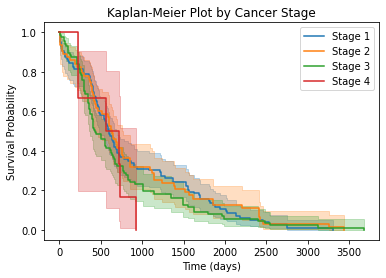

In [82]:
stage1_survival = surv_Data[surv_Data['pathologic_stage'] == 1]['Survival']
stage1_event = surv_Data[surv_Data['pathologic_stage'] == 1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

stage2_survival = surv_Data[surv_Data['pathologic_stage'] == 2]['Survival']
stage2_event = surv_Data[surv_Data['pathologic_stage'] == 2]['Survival'].apply(lambda x: 0 if x == 1 else 1)

stage3_survival = surv_Data[surv_Data['pathologic_stage'] == 3]['Survival']
stage3_event = surv_Data[surv_Data['pathologic_stage'] == 3]['Survival'].apply(lambda x: 0 if x == 1 else 1)

stage4_survival = surv_Data[surv_Data['pathologic_stage'] == 4]['Survival']
stage4_event = surv_Data[surv_Data['pathologic_stage'] == 4]['Survival'].apply(lambda x: 0 if x == 1 else 1)


kmf_stage1 = KaplanMeierFitter()
kmf_stage1.fit(stage1_survival, event_observed=stage1_event)

kmf_stage2 = KaplanMeierFitter()
kmf_stage2.fit(stage2_survival, event_observed=stage2_event)

kmf_stage3 = KaplanMeierFitter()
kmf_stage3.fit(stage3_survival, event_observed=stage3_event)

kmf_stage4 = KaplanMeierFitter()
kmf_stage4.fit(stage4_survival, event_observed=stage4_event)

plt.figure()
kmf_stage1.plot(label='Stage 1')
kmf_stage2.plot(label='Stage 2')
kmf_stage3.plot(label='Stage 3')
kmf_stage4.plot(label='Stage 4')

plt.title('Kaplan-Meier Plot by Cancer Stage')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()




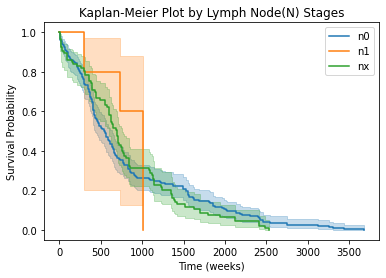

In [83]:
stage0_survival = surv_Data[surv_Data['pathology_N_stage'] == 0.1]['Survival']
stage0_event = surv_Data[surv_Data['pathology_N_stage'] == 0.1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

stage1_survival = surv_Data[surv_Data['pathology_N_stage'] == 1]['Survival']
stage1_event = surv_Data[surv_Data['pathology_N_stage'] == 1]['Survival'].apply(lambda x: 0 if x == 1 else 1)

stagex_survival = surv_Data[surv_Data['pathology_N_stage'] == 0]['Survival']
stagex_event = surv_Data[surv_Data['pathology_N_stage'] == 0]['Survival'].apply(lambda x: 0 if x == 1 else 1)

kmf_stage0 = KaplanMeierFitter()
kmf_stage0.fit(stage0_survival, event_observed=stage0_event)

kmf_stage1 = KaplanMeierFitter()
kmf_stage1.fit(stage1_survival, event_observed=stage1_event)


kmf_stagex = KaplanMeierFitter()
kmf_stagex.fit(stagex_survival, event_observed=stagex_event)

plt.figure()
kmf_stage0.plot(label='n0')
kmf_stage1.plot(label='n1')
kmf_stagex.plot(label='nx')

plt.title('Kaplan-Meier Plot by Lymph Node(N) Stages')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')

plt.legend()
plt.show()



# Predicting number of days till person survives for Censored data

In [84]:
Censored_data.head() #censored data

,SOX15.6665,HLA.J.3137,HPS3.84343,FFAR3.2865,SCGB2A2.4250,C22orf15.150248,hsa.mir.215,WDR88.126248,GPR89A.653519,rs10936224,...,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,,,,,,,
TCGA-2Y-A9H0-01,3.7535,130.1658,1564.4166,1.8768,0.0000,22.5211,61.454705,2.5023,1004.6919,-0.046967,...,3,3.0,0.1,2,2,2004,1,1,0.1,4
TCGA-3K-AAZ8-01,11.2755,5.0740,1494.6864,0.5638,0.0000,0.5638,87.791223,0.0000,722.7625,-2.171288,...,3,3.2,0.0,0,2,2013,1,1,0.0,3
TCGA-5R-AA1D-01,8.2930,1.3822,797.9267,1.3822,0.0000,2.7643,260.283161,0.0000,800.9675,-0.197217,...,3,3.1,0.1,2,1,2013,2,1,0.1,1
TCGA-BC-4073-01,9.1491,6.1070,963.1930,11.8939,2.7447,4.5746,474.334293,10.0640,812.9003,-4.587531,...,3,3.0,0.1,0,2,2009,1,1,1.0,1
TCGA-BC-A216-01,5.6037,24.4727,1047.2440,5.0942,0.0000,3.0565,181.366221,4.0754,1313.8054,-0.216848,...,3,3.0,0.0,2,1,2008,1,1,0.1,1


In [85]:
print(Censored_data.iloc[:, -20:].isna().sum())


ALPP.250                                  0
YIPF1.54432                               0
MYBPC1.4604                               0
ZNF876P.642280                            0
cg23212796                                0
Survival                                  0
Death                                     0
years_to_birth                            0
days_to_death                           136
days_to_last_followup                     0
pathologic_stage                          0
pathology_T_stage                         0
pathology_N_stage                         0
pathology_M_stage                         0
gender                                    0
date_of_initial_pathologic_diagnosis      0
radiation_therapy                         0
histological_type                         0
residual_tumor                            0
race                                      0
dtype: int64


In [86]:
#since the people had not died, the column "days_to_death" is null. This can be dropped now. Days to last followup is same as Survival
rows_Combination3 = rows_Combination3.drop(['days_to_death','days_to_last_followup'], axis=1)

In [87]:
from lifelines import WeibullAFTFitter

# WeibullAFTFitter
wf = WeibullAFTFitter().fit(surv_Data, "Survival", "Death")

# filter down to just censored subjects to predict remaining survival
censored_subjects = Censored_data
censored_subjects_last_obs = censored_subjects['Survival']

# predict new survival function
wf.predict_survival_function(censored_subjects, conditional_after=censored_subjects_last_obs)

# predict median remaining life
print('Median Remaining life for the subjects (in number of days):')
wf.predict_median(censored_subjects, conditional_after=censored_subjects_last_obs)

Median Remaining life for the subjects (in number of days):


TCGA-2Y-A9H0-01      9639.774149
TCGA-3K-AAZ8-01      1984.383693
TCGA-5R-AA1D-01     11607.455700
TCGA-BC-4073-01      1266.508153
TCGA-BC-A216-01       679.976862
                       ...      
TCGA-ED-A5KG-01    206459.791867
TCGA-WX-AA46-01      2153.342464
TCGA-ZS-A9CE-01      1338.146283
TCGA-DD-AAVX-01     10813.401705
TCGA-DD-AAVV-01       965.069065
Length: 136, dtype: float64

In [88]:
censored_subjects.loc[['TCGA-ED-A5KG-01'], censored_subjects.columns[-15:]]


,Survival,Death,years_to_birth,days_to_death,days_to_last_followup,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,
TCGA-ED-A5KG-01,854.0,0.0,60,NaN,854,2,2.0,0.1,2,1,2012,1,1,0.1,2


In [89]:
censored_subjects.loc[['TCGA-2Y-A9H0-01'], censored_subjects.columns[-15:]]


,Survival,Death,years_to_birth,days_to_death,days_to_last_followup,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,
TCGA-2Y-A9H0-01,3675.0,0.0,49,NaN,3675,3,3.0,0.1,2,2,2004,1,1,0.1,4


In [90]:
#do analysis only for features with hazard ratio >1

sig_feat_list = [covariate for covariate, score in col_coef.items() if score > 1]


In [91]:
Censored_data2 = Censored_data[sig_feat_list + ["Survival", "Death"]].copy()

surv_Data2 = surv_Data[sig_feat_list + ["Survival", "Death"]].copy()

In [92]:

# WeibullAFTFitter
wf = WeibullAFTFitter().fit(surv_Data2, "Survival", "Death")

# filter down to just censored subjects to predict remaining survival
censored_subjects = Censored_data2
censored_subjects_last_obs = censored_subjects['Survival']

# predict new survival function
wf.predict_survival_function(censored_subjects, conditional_after=censored_subjects_last_obs)

# predict median remaining life
print('Median Remaining life for the subjects (in number of days):')
wf.predict_median(censored_subjects, conditional_after=censored_subjects_last_obs)

Median Remaining life for the subjects (in number of days):


TCGA-2Y-A9H0-01     3299.864105
TCGA-3K-AAZ8-01     1316.277934
TCGA-5R-AA1D-01     1918.261569
TCGA-BC-4073-01     1531.114266
TCGA-BC-A216-01      754.191344
                       ...     
TCGA-ED-A5KG-01    77936.886631
TCGA-WX-AA46-01     2038.769987
TCGA-ZS-A9CE-01     1655.645577
TCGA-DD-AAVX-01     2580.622856
TCGA-DD-AAVV-01      849.693160
Length: 136, dtype: float64

The median life dramtically decreases if the columns that we use are only with high hazard ratio. The selected covariates might speed up the occurrence of the event as is suggested by the high hazard ratio, leading to a decrease in the median survival time. The previous analysis with other columns(found to be significant by svm) are a better predictor for the number of days overall.

# 2\. on significant features obtained by Gradient Boost which was run on data reduced by differential analysis

In [219]:
#features with importance score > 0.0015, arbitrarily chosen after analysing the bar plot, i wanted features to be more than 100
filtered_features = gb_diff_results[gb_diff_results.iloc[:, 1] > 0.0015] 
filtered_features.shape

(102, 2)

In [220]:
#get all the information for the significant columns directly from the merged data
filt_cols = merged_data[filtered_features.iloc[:, 0].tolist()]
filt_cols.shape

(305, 102)

In [221]:
#Remove columns with variance less than 1
num_Data=pd.DataFrame(filt_cols[filt_cols.select_dtypes(include=[np.number]).columns])
low_variance_columns=num_Data.columns[num_Data.var() <= 1] #checking all columns that have varience less than 1
filt_cols.drop(low_variance_columns, axis=1, inplace=True) #drop dolumns with low varience
filt_cols.shape

C:\Users\shubh\AppData\Local\Temp\ipykernel_18124\1706613807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_cols.drop(low_variance_columns, axis=1, inplace=True) #drop dolumns with low varience


(305, 102)

In [222]:
surv_Data = pd.merge(filt_cols, clinical_Data, left_index=True, right_index=True, how="left") #merge the columns data with clincial data
surv_Data.head()

,NCRNA00162.378825,KRTAP1.1.81851,FRMD1.79981,EPO.2056,SAGE1.55511,KLK3.354,SNORD15B.114599,CLSTN2.64084,C14orf180.400258,CEACAM5.1048,...,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race,ethnicity
PatientID,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01,1.3031,0.0000,1.9547,11.7283,0.0,0.0,0.0,6.5157,0.0000,222.186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-2Y-A9GS-01,0.0000,0.4929,0.4929,0.0000,0.0,0.0,0.0,4.9285,0.4929,0.000,...,t2,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,hispanic or latino
TCGA-2Y-A9GT-01,0.0000,0.0000,0.0000,9.8633,0.0,0.0,0.0,9.8633,0.0000,0.000,...,t1,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GV-01,0.0000,0.0000,0.0000,12.6904,0.0,0.0,0.0,4.2301,0.0000,0.846,...,t1,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino
TCGA-2Y-A9GW-01,0.7663,0.0000,0.0000,106.5134,0.0,0.0,0.0,9.1954,2.2989,0.000,...,t1,n0,mx,male,2007,no,hepatocellular carcinoma,r0,white,not hispanic or latino


##### Taking care of the null values

In [223]:
surv_Data.isna().sum()

NCRNA00162.378825     0
KRTAP1.1.81851        0
FRMD1.79981           0
EPO.2056              0
SAGE1.55511           0
                     ..
radiation_therapy    28
histological_type     9
residual_tumor       15
race                 19
ethnicity            27
Length: 121, dtype: int64

In [224]:
print(surv_Data.iloc[:, -20:].isna().sum())


CLEC4M.10332                              0
Survival                                  6
Death                                     6
PatientIDx                                9
years_to_birth                           13
vital_status                              9
days_to_death                           150
days_to_last_followup                   121
tumor_tissue_site                         9
pathologic_stage                         39
pathology_T_stage                        10
pathology_N_stage                        11
pathology_M_stage                         9
gender                                    9
date_of_initial_pathologic_diagnosis     11
radiation_therapy                        28
histological_type                         9
residual_tumor                           15
race                                     19
ethnicity                                27
dtype: int64


In [225]:
surv_Data = surv_Data.dropna(subset=['Death','years_to_birth']) #since these columns are important for the analysis

surv_Data = surv_Data.drop(['PatientIDx'], axis=1) #we already have this data as column id

surv_Data.loc[surv_Data['ethnicity'] == 'hispanic or latino', 'race'] = 'white (hispanic or latino)' #one column will suffice
surv_Data = surv_Data.drop(['ethnicity'], axis=1)


surv_Data = surv_Data.drop(['vital_status'], axis=1) #same as Survival

col_na = ['pathologic_stage', 'pathology_T_stage', 'pathology_N_stage', 'pathology_M_stage', 'date_of_initial_pathologic_diagnosis', 'residual_tumor', 'radiation_therapy', 'histological_type', 'race', 'tumor_tissue_site']
surv_Data[col_na] = surv_Data[col_na].fillna(0) #the values inside these variables will be dealt with later

print(surv_Data.iloc[:, -20:].isna().sum())
surv_Data.shape


SPINK5.11005                              0
ANO2.57101                                0
cg10530851                                0
CLEC4M.10332                              0
Survival                                  0
Death                                     0
years_to_birth                            0
days_to_death                           136
days_to_last_followup                   110
tumor_tissue_site                         0
pathologic_stage                          0
pathology_T_stage                         0
pathology_N_stage                         0
pathology_M_stage                         0
gender                                    0
date_of_initial_pathologic_diagnosis      0
radiation_therapy                         0
histological_type                         0
residual_tumor                            0
race                                      0
dtype: int64


(288, 118)

days_to_death and days_to_last_followup are important for finding the censoring data

In [226]:
combination_1 = ((surv_Data['days_to_death'].notnull()) & (surv_Data['days_to_last_followup'].isnull())).sum()
combination_2 = ((surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].notnull())).sum()
combination_3 = ((surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].isnull())).sum() #both null
combination_4 = ((surv_Data['days_to_death'].notnull()) & (surv_Data['days_to_last_followup'].notnull())).sum() #both has data

print('Combination 1 = days_to_death is filled, days_to_last_followup is null\nCombination 2 = days_to_death is null, days_to_last_followup is filled\nCombination 3 = Both are null\nCombination 4 = Both are filled')
# Print the frequencies
print("\nCombination 1 frequency:", combination_1)
print("Combination 2 frequency:", combination_2)
print("Combination 3 frequency:", combination_3)
print("Combination 4 frequency:", combination_4)

Combination 1 = days_to_death is filled, days_to_last_followup is null
Combination 2 = days_to_death is null, days_to_last_followup is filled
Combination 3 = Both are null
Combination 4 = Both are filled

Combination 1 frequency: 110
Combination 2 frequency: 136
Combination 3 frequency: 0
Combination 4 frequency: 42


In [227]:

surv_Data.loc[(surv_Data['days_to_death'].notnull()) & (surv_Data['days_to_last_followup'].notnull())].iloc[:, -20:]


,SPINK5.11005,ANO2.57101,cg10530851,CLEC4M.10332,Survival,Death,years_to_birth,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,,,,,,
TCGA-4R-AA8I-01,209.4780,11.6758,-3.778129,0.0000,262.0,1.0,66,262,216,liver,stage ii,t2,nx,mx,male,2013,no,hepatocellular carcinoma,r0,white
TCGA-BC-A217-01,140.8064,1.4979,-4.587674,1.4979,1397.0,1.0,75,1397,421,liver,stage ii,t2,nx,m0,female,2010,no,hepatocellular carcinoma,r0,white
TCGA-BC-A5W4-01,3.3162,0.8290,-1.611417,0.0000,547.0,1.0,69,547,289,liver,stage iii,t3a,nx,m0,male,2012,no,hepatocellular carcinoma,r1,white
TCGA-CC-5258-01,0.0000,0.9519,-5.607172,1.9039,129.0,1.0,48,129,0,liver,stage ii,t2,n0,m0,male,2010,no,hepatocellular carcinoma,rx,asian
TCGA-CC-5260-01,1.1850,1.7775,0.323893,0.0000,87.0,1.0,61,87,0,liver,stage iii,t4,n0,m0,female,2010,no,hepatocellular carcinoma,rx,asian
TCGA-CC-5261-01,5.4832,3.4270,1.639961,2.0562,97.0,1.0,44,97,12,liver,stage ii,t2,n0,m0,male,2010,no,hepatocellular carcinoma,rx,asian
TCGA-CC-5262-01,6.2884,4.4019,-0.272851,3.1442,103.0,1.0,67,103,0,liver,stage iii,t4,n0,m0,male,2010,no,hepatocellular carcinoma,0,asian
TCGA-CC-5264-01,24.4952,1.9861,-4.969266,0.9930,102.0,1.0,71,102,0,liver,stage iii,t3,n0,m0,male,2010,no,hepatocellular carcinoma,rx,asian
TCGA-CC-A1HT-01,97.0584,155.8899,-3.394957,0.0000,101.0,1.0,50,101,0,liver,stage iii,t3,n0,m0,male,2010,no,hepatocellular carcinoma,0,asian


data for all the above columns are for the patients who died

In [228]:
surv_Data.loc[(surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].notnull())].iloc[:, -20:]


,SPINK5.11005,ANO2.57101,cg10530851,CLEC4M.10332,Survival,Death,years_to_birth,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,,,,,,
TCGA-2Y-A9H0-01,38.1608,1.8768,-2.501965,0.0000,3675.0,0.0,49,NaN,3675,liver,stage iii,t3,n0,m0,male,2004,no,hepatocellular carcinoma,r0,white (hispanic or latino)
TCGA-3K-AAZ8-01,0.0000,3.9464,-0.468791,0.0000,396.0,0.0,65,NaN,396,liver,stage iii,t3b,nx,mx,male,2013,no,hepatocellular carcinoma,rx,black or african american
TCGA-5R-AA1D-01,40.7740,7.6019,-5.137914,0.6911,449.0,0.0,17,NaN,449,liver,stage iii,t3a,n0,m0,female,2013,yes,hepatocellular carcinoma,r0,white
TCGA-BC-4073-01,55.8097,10.0640,-3.376790,0.9149,849.0,0.0,73,NaN,849,liver,stage iii,t3,n0,mx,male,2009,no,hepatocellular carcinoma,r1,white
TCGA-BC-A216-01,357.1065,15.7922,-0.533393,0.0000,1351.0,0.0,62,NaN,1351,liver,stage iii,t3,nx,m0,female,2008,no,hepatocellular carcinoma,r0,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ED-A5KG-01,16.6415,5.0429,-0.089951,0.0000,854.0,0.0,60,NaN,854,liver,stage ii,t2,n0,m0,female,2012,no,hepatocellular carcinoma,r0,asian
TCGA-WX-AA46-01,4.2042,11.4114,-3.982811,174.7748,756.0,0.0,61,NaN,756,liver,stage ii,t2,nx,mx,male,2012,no,hepatocellular carcinoma,r0,white
TCGA-ZS-A9CE-01,3.8293,1.6411,1.238725,22.4289,1241.0,0.0,79,NaN,1241,liver,stage ii,t2,nx,mx,female,2011,no,hepatocellular carcinoma,r0,white


data for all the above columns are for the patients who were still alive but the data for the future was not available. nor it was specified if they made recovery. this will be our censored data and will be used for the anlaysis later on to check how many days did the proceed to live.

In [229]:
rows_Combination3 = surv_Data.loc[(surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].notnull())]
count = (rows_Combination3['Death'] == 0).sum()
print(count)

136


Combination 1 and Combination 4, Death = 1;     
Combination 3, Death = 0

In [230]:
surv_Data.iloc[:, -13:]

,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,
TCGA-2Y-A9GS-01,724,NaN,liver,stage iv,t2,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white (hispanic or latino)
TCGA-2Y-A9GT-01,1624,NaN,liver,stage i,t1,nx,mx,male,2006,no,hepatocellular carcinoma,r0,white
TCGA-2Y-A9GV-01,2532,NaN,liver,stage i,t1,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white
TCGA-2Y-A9GW-01,1271,NaN,liver,stage i,t1,n0,mx,male,2007,no,hepatocellular carcinoma,r0,white
TCGA-2Y-A9GY-01,757,NaN,liver,stage ii,t2,nx,mx,female,2007,no,hepatocellular carcinoma,r0,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ED-A5KG-01,NaN,854,liver,stage ii,t2,n0,m0,female,2012,no,hepatocellular carcinoma,r0,asian
TCGA-WX-AA46-01,NaN,756,liver,stage ii,t2,nx,mx,male,2012,no,hepatocellular carcinoma,r0,white
TCGA-ZS-A9CE-01,NaN,1241,liver,stage ii,t2,nx,mx,female,2011,no,hepatocellular carcinoma,r0,white


Refining the clinical data. Making every string value into a number since the data is categorical and more than that survival aanlsysis only accepts nmerical data.

In [231]:
surv_Data['Death'].value_counts()

1.0    152
0.0    136
Name: Death, dtype: int64

Imbalance ratio is not severe, is close to 1. We will continue without balancing the data

In [232]:
surv_Data['tumor_tissue_site'].value_counts()

liver    288
Name: tumor_tissue_site, dtype: int64

can be dropped

In [233]:
surv_Data.drop('tumor_tissue_site', axis=1, inplace=True)

In [234]:
surv_Data['pathologic_stage'].value_counts()

stage i      103
stage iii     87
stage ii      63
0             29
stage iv       6
Name: pathologic_stage, dtype: int64

In [235]:
surv_Data['pathology_T_stage'].value_counts()

t1     116
t2      70
t3      46
t3a     29
t4      16
t3b      7
tx       1
0        1
t2a      1
t2b      1
Name: pathology_T_stage, dtype: int64

In [236]:
surv_Data['pathology_M_stage'].value_counts()

m0    203
mx     81
m1      4
Name: pathology_M_stage, dtype: int64

In [237]:
surv_Data['pathology_N_stage'].value_counts()

n0    190
nx     91
n1      5
0       2
Name: pathology_N_stage, dtype: int64

In [238]:
surv_Data['gender'].value_counts()

male      186
female    102
Name: gender, dtype: int64

In [239]:
surv_Data['date_of_initial_pathologic_diagnosis'].value_counts()

2013    58
2012    37
2011    36
2010    26
2008    24
2007    17
2009    15
2005    12
2002    11
2006    10
1998     8
2003     7
2000     6
2001     5
1999     5
1996     3
2004     3
1995     2
0        2
1997     1
Name: date_of_initial_pathologic_diagnosis, dtype: int64

In [240]:
med = surv_Data.loc[surv_Data['date_of_initial_pathologic_diagnosis'] != 0, 'date_of_initial_pathologic_diagnosis'].median()
surv_Data['date_of_initial_pathologic_diagnosis'].replace(0, med, inplace=True)
surv_Data['date_of_initial_pathologic_diagnosis'].value_counts()

2013      58
2012      37
2011      36
2010      26
2008      24
2007      17
2009      15
2005      12
2002      11
2006      10
1998       8
2003       7
2000       6
2001       5
1999       5
1996       3
2004       3
1995       2
2010.0     2
1997       1
Name: date_of_initial_pathologic_diagnosis, dtype: int64

In [241]:
surv_Data['radiation_therapy'].value_counts()

no     266
0       16
yes      6
Name: radiation_therapy, dtype: int64

In [242]:
surv_Data['histological_type'].value_counts()

hepatocellular carcinoma            283
hepatocholangiocarcinoma (mixed)      5
Name: histological_type, dtype: int64

In [243]:
surv_Data['residual_tumor'].value_counts()

r0    249
rx     16
r1     15
0       6
r2      2
Name: residual_tumor, dtype: int64

In [244]:
surv_Data['race'].value_counts()

white                               142
asian                               108
black or african american            18
white (hispanic or latino)           10
0                                     9
american indian or alaska native      1
Name: race, dtype: int64

In [245]:
stage_mapping = {
    'stage i': 1,
    'stage ii': 2,
    'stage iii': 3,
    'stage iv': 4}

t_mapping = {
    't1': 1,
    't2': 2,
    't2a': 2.1,
    't2b': 2.2,
    't3': 3,
    't3a': 3.1,
    't3b': 3.2,
    't4': 4,
    'tx': 0}

n_mapping = {
    'n0': 0.1,
    'n1': 1,
    'n2': 2,
    'nx': 0}  


m_mapping = {
    'm0': 2,
    'm1': 1,
    'mx': 0}

gender_mapping = {
    'female': 1,
    'male': 2}

rad_th = {
    'no':1,
    'yes':2}

residual_t = {
    'r0':0.1,
    'rx':0,
    'r1':1,
    'r2':2,
}

hist_type = {
    'hepatocellular carcinoma' :1,
'hepatocholangiocarcinoma (mixed)':2}

race_mapping = {
    'white' :1,
    'asian' :2,
    'black or african american':3,
    'white (hispanic or latino)':4,
    'american indian or alaska native':5
}

surv_Data['pathologic_stage'] = surv_Data['pathologic_stage'].replace(stage_mapping)
surv_Data['pathology_T_stage'] = surv_Data['pathology_T_stage'].replace(t_mapping)
surv_Data['pathology_N_stage'] = surv_Data['pathology_N_stage'].replace(n_mapping)
surv_Data['pathology_M_stage'] = surv_Data['pathology_M_stage'].replace(m_mapping)
surv_Data['gender'] = surv_Data['gender'].replace(gender_mapping)
surv_Data['radiation_therapy'] = surv_Data['radiation_therapy'].replace(rad_th)
surv_Data['residual_tumor'] = surv_Data['residual_tumor'].replace(residual_t)
surv_Data['histological_type'] = surv_Data['histological_type'].replace(hist_type)
surv_Data['race'] = surv_Data['race'].replace(race_mapping)
print(surv_Data.iloc[:, -20:].isna().sum())
surv_Data.shape

RAB25.57111                               0
SPINK5.11005                              0
ANO2.57101                                0
cg10530851                                0
CLEC4M.10332                              0
Survival                                  0
Death                                     0
years_to_birth                            0
days_to_death                           136
days_to_last_followup                   110
pathologic_stage                          0
pathology_T_stage                         0
pathology_N_stage                         0
pathology_M_stage                         0
gender                                    0
date_of_initial_pathologic_diagnosis      0
radiation_therapy                         0
histological_type                         0
residual_tumor                            0
race                                      0
dtype: int64


(288, 117)

In [246]:
#Separate Censored data for later where we predict median number of days left to live 
Censored_data = surv_Data.loc[(surv_Data['days_to_death'].isnull()) & (surv_Data['days_to_last_followup'].notnull())]

In [247]:
#Drop columns days_to_death and days_to_last_followup for survival analysis. We have Survical column which has combination of that data in it
surv_Data = surv_Data.drop(['days_to_death','days_to_last_followup'], axis=1)


# Survival Analysis

C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column REG3G.130120 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Death'].astype(bool)
>>> print(df.loc[events, 'REG3G.130120'].var())
>>> print(df.loc[~events, 'REG3G.130120'].var())

A very low variance means that the column REG3G.130120 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\shubh\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lif

<lifelines.CoxPHFitter: fitted with 288 total observations, 136 right-censored observations>
             duration col = 'Survival'
                event col = 'Death'
      baseline estimation = breslow
   number of observations = 288
number of events observed = 152
   partial log-likelihood = -599.44
         time fit was run = 2023-07-20 23:01:42 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                    
NCRNA00162.378825                     -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
KRTAP1.1.81851                         0.01       1.01       0.05            -0.08             0.10                 0.92                 1.10
FRMD1.79981                            0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
EPO.2056                               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SAGE1.55511                           -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
KLK3.354                               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SNORD15B.114599                       -0.29       0.75       0.15            -0.58             0.01                 0.56                 1.01
CLSTN2.64084                          -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
C14orf180.400258                       0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
CEACAM5.1048                          -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
MAG.4099                               0.01       1.01       0.01            -0.02             0.03                 0.98                 1.03
ART5.116969                           -0.01       0.99       0.00            -0.02             0.00                 0.98                 1.00
APOL5.80831                           -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
HOXC8.3224                            -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
cg13745593                             0.05       1.05       0.11            -0.16             0.27                 0.85                 1.31
cg00674365                            -0.01       0.99       0.07            -0.15             0.12                 0.86                 1.13
GAGE4.2576                             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
DRD1.1812                             -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
IL13RA2.3598                          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
STMN4.81551                            0.01       1.01       0.02            -0.02             0.05                 0.98                 1.05
CSF3.1440                              0.08       1.08       0.03             0.02             0.14                 1.02                 1.15
MARCO.8685                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IRX2.153572                           -0.04       0.96       0.06            -0.15             0.07                 0.86                 1.08
HRASLS.57110                          -0.05       0.95       0.03            -0.11       

<AxesSubplot:xlabel='log(HR) (95% CI)'>

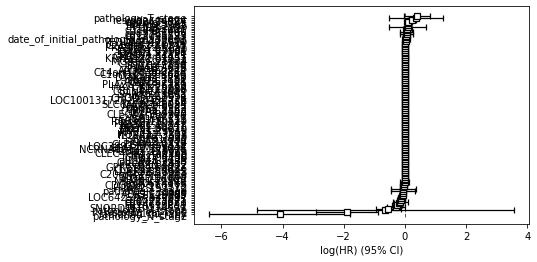

In [248]:
cph = CoxPHFitter()
cph.fit(surv_Data, duration_col='Survival', event_col='Death')
cph.print_summary()
cph.plot()

In [249]:
# hazard ratios + CI
hazard_ratios = cph.summary['exp(coef)']
ci_lower = cph.summary['exp(coef) lower 95%']
ci_upper = cph.summary['exp(coef) upper 95%']

results = pd.DataFrame({
    'Variable': hazard_ratios.index,
    'Hazard Ratio': hazard_ratios.values,
    'CI Lower': ci_lower.values,
    'CI Upper': ci_upper.values
})
print(results)

                                 Variable  Hazard Ratio  CI Lower   CI Upper
0                       NCRNA00162.378825      0.998920  0.982098   1.016031
1                          KRTAP1.1.81851      1.010645  0.924435   1.104895
2                             FRMD1.79981      1.014689  1.002994   1.026521
3                                EPO.2056      1.001185  0.999928   1.002444
4                             SAGE1.55511      0.999923  0.993135   1.006758
..                                    ...           ...       ...        ...
108  date_of_initial_pathologic_diagnosis      1.050577  0.966617   1.141829
109                     radiation_therapy      0.150820  0.054003   0.421213
110                     histological_type      0.526505  0.007945  34.888798
111                        residual_tumor      1.449468  0.595962   3.525323
112                                  race      0.940190  0.644100   1.372391

[113 rows x 4 columns]


In [250]:
#top features
col_coef = cph.summary['exp(coef)'].abs().sort_values(ascending=False)
print("\nSorted features based on hazard ratios:")
print(col_coef.head(50))


Sorted features based on hazard ratios:
covariate
pathology_T_stage                       1.487714
residual_tumor                          1.449468
cg02604524                              1.264061
cg08435683                              1.116080
KCNJ9.3765                              1.101606
EPHA8.2046                              1.099110
gender                                  1.095487
cg14453201                              1.085351
CSF3.1440                               1.082424
cg07765706                              1.063662
cg13745593                              1.054924
cg12036633                              1.051891
date_of_initial_pathologic_diagnosis    1.050577
cg10272601                              1.022649
TEDDM1.127670                           1.020686
years_to_birth                          1.019197
C21orf62.56245                          1.018372
PRAMEF1.65121                           1.016513
P2RY4.5030                              1.016246
FRMD1.79981       

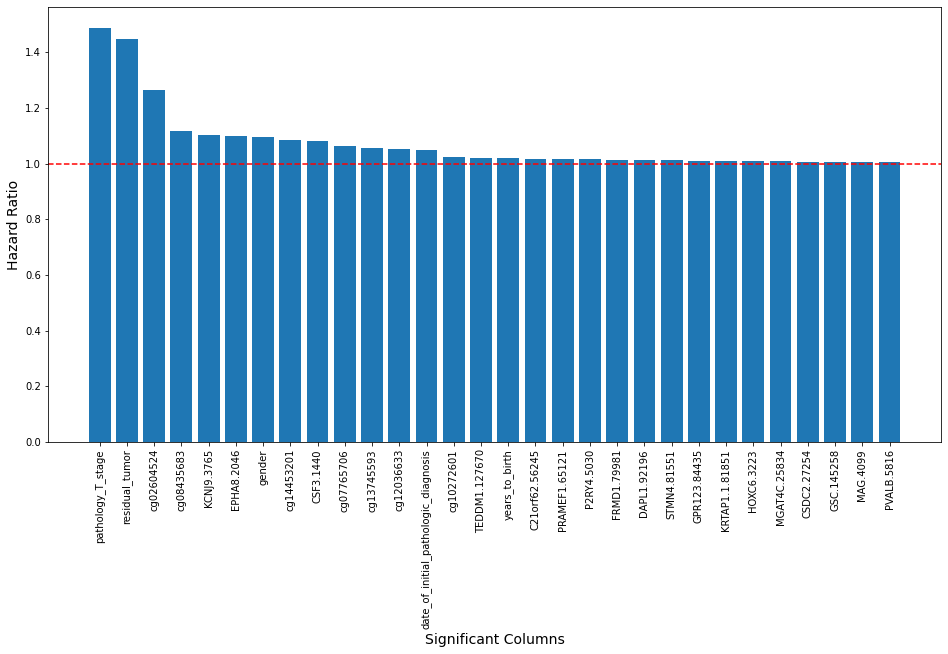

In [251]:
top_50_hazard_ratios = col_coef.head(30)
plt.figure(figsize=(16, 8))
plt.bar(top_50_hazard_ratios.index, top_50_hazard_ratios)
plt.xticks(rotation=90)
plt.axhline(y=1, color='red', linestyle='--', label='Hazard Ratio = 1')
plt.xlabel('Significant Columns', fontsize=14)  
plt.ylabel('Hazard Ratio', fontsize=14)  

plt.show()

Analysing KM plots - Since the number of samples did not change, only the colums are different for this analysis, hence it will not make sense to make same plots all over again.

# Predicting number of days till person survives for Censored data

In [252]:
Censored_data.head() #censored data

,NCRNA00162.378825,KRTAP1.1.81851,FRMD1.79981,EPO.2056,SAGE1.55511,KLK3.354,SNORD15B.114599,CLSTN2.64084,C14orf180.400258,CEACAM5.1048,...,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,,,,,,,
TCGA-2Y-A9H0-01,0.0000,0.0000,1.8768,516.7344,175.7898,611.8236,0.0000,0.6256,0.0000,3.1279,...,3,3.0,0.1,2,2,2004,1,1,0.1,4
TCGA-3K-AAZ8-01,0.0000,0.0000,0.5638,1.6913,0.0000,0.0000,0.0000,3.3827,0.0000,5.6378,...,3,3.2,0.0,0,2,2013,1,1,0.0,3
TCGA-5R-AA1D-01,2.0733,1.3822,0.6911,96.0608,0.0000,0.0000,0.0000,62.1977,0.0000,1.3822,...,3,3.1,0.1,2,1,2013,2,1,0.1,1
TCGA-BC-4073-01,0.0000,0.4575,0.9149,987.6487,3.6597,0.0000,7.3193,6.8618,0.9149,0.9149,...,3,3.0,0.1,0,2,2009,1,1,1.0,1
TCGA-BC-A216-01,0.0000,0.0000,20.8864,1392.2567,5.0942,70.3006,6.6225,1.5283,0.0000,8202.2415,...,3,3.0,0.0,2,1,2008,1,1,0.1,1


In [253]:
print(Censored_data.iloc[:, -20:].isna().sum())


RAB25.57111                               0
SPINK5.11005                              0
ANO2.57101                                0
cg10530851                                0
CLEC4M.10332                              0
Survival                                  0
Death                                     0
years_to_birth                            0
days_to_death                           136
days_to_last_followup                     0
pathologic_stage                          0
pathology_T_stage                         0
pathology_N_stage                         0
pathology_M_stage                         0
gender                                    0
date_of_initial_pathologic_diagnosis      0
radiation_therapy                         0
histological_type                         0
residual_tumor                            0
race                                      0
dtype: int64


In [254]:
#since the people had not died, the column "days_to_death" is null. This can be dropped now. Days to last followup is same as Survival
rows_Combination3 = rows_Combination3.drop(['days_to_death','days_to_last_followup'], axis=1)

In [255]:
#getting high variance error for 'MT1B.4490' 
print((surv_Data['MT1B.4490'] > 10000).sum())
print((surv_Data['MT1B.4490'] > 1000).sum())
print((surv_Data['MT1B.4490'] > 100).sum())
print((surv_Data['MT1B.4490'] > 10).sum())
print((surv_Data['MT1B.4490'] > 0).sum())

surv_Data['MT1B.4490'].shape # we can replace outlier with median

2
3
7
22
73


(288,)

In [261]:
med=surv_Data['MT1B.4490'].median()



#getting high variance error for 'MT1B.4490' 
print((surv_Data['MT1B.4490'] > 10000).sum())
print((surv_Data['MT1B.4490'] > 1000).sum())
print((surv_Data['MT1B.4490'] > 100).sum())
print((surv_Data['MT1B.4490'] > 10).sum())
print((surv_Data['MT1B.4490'] > 0).sum())
print((surv_Data['MT1B.4490'] == 0).sum())

med # we can replace outlier with median

2
3
7
22
73
215


0.0

In [271]:
#most of the data is in zeroes. it will be better to drop it
surv_Data = surv_Data.drop(['MT1B.4490','REG3G.130120'],axis=1)

In [288]:
# WeibullAFTFitter 
wf = WeibullAFTFitter(penalizer=0.009).fit(surv_Data, "Survival", "Death")

# filter down to just censored subjects to predict remaining survival
censored_subjects = Censored_data
censored_subjects_last_obs = censored_subjects['Survival']

# predict new survival function
wf.predict_survival_function(censored_subjects, conditional_after=censored_subjects_last_obs)

# predict median remaining life
print('Median Remaining life for the subjects (in number of days):')
wf.predict_median(censored_subjects, conditional_after=censored_subjects_last_obs)

Median Remaining life for the subjects (in number of days):


TCGA-2Y-A9H0-01      704.242887
TCGA-3K-AAZ8-01     3344.012300
TCGA-5R-AA1D-01     2286.400961
TCGA-BC-4073-01    55625.259955
TCGA-BC-A216-01     9472.361768
                       ...     
TCGA-ED-A5KG-01      637.281141
TCGA-WX-AA46-01     1868.851729
TCGA-ZS-A9CE-01     3585.812047
TCGA-DD-AAVX-01     7395.783381
TCGA-DD-AAVV-01      841.434871
Length: 136, dtype: float64

In [274]:
censored_subjects.loc[['TCGA-ED-A5KG-01'], censored_subjects.columns[-15:]]


,Survival,Death,years_to_birth,days_to_death,days_to_last_followup,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,
TCGA-ED-A5KG-01,854.0,0.0,60,NaN,854,2,2.0,0.1,2,1,2012,1,1,0.1,2


In [275]:
censored_subjects.loc[['TCGA-2Y-A9H0-01'], censored_subjects.columns[-15:]]


,Survival,Death,years_to_birth,days_to_death,days_to_last_followup,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,histological_type,residual_tumor,race
PatientID,,,,,,,,,,,,,,,
TCGA-2Y-A9H0-01,3675.0,0.0,49,NaN,3675,3,3.0,0.1,2,2,2004,1,1,0.1,4
